In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import pandas as pd
import random
import ntpath
from PIL import Image
from sklearn.utils import shuffle
import glob
from sklearn.model_selection import train_test_split
import torchvision.models as models


In [2]:
!git clone https://github.com/abhinavsagar/Self-Driving-Car.git


Cloning into 'Self-Driving-Car'...
remote: Enumerating objects: 5309, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 5309 (delta 16), reused 0 (delta 0), pack-reused 5282
Receiving objects: 100% (5309/5309), 85.58 MiB | 37.02 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
## Keras
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import ResNet50#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [4]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)

  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

In [5]:
def img_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (100, 100))
    img = img / 255
    return img
def get_data():
    data = pd.read_csv(os.path.join('./Self-Driving-Car/', 'driving_log.csv'), names = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
    img1 = []
    img2 = []
    img3 = []
    label1 = []
    label2 = []
    label3 = []
    for i in range(len(data)):
        if i == 0: 
            continue
        img1.append(img_preprocess(mpimg.imread("./Self-Driving-Car/IMG/"+data.iloc[i][0].replace(" ","").split('\\')[-1])))
        img2.append(img_preprocess(mpimg.imread("./Self-Driving-Car/IMG//"+data.iloc[i][1].replace(" ","").split('\\')[-1])))
        img3.append(img_preprocess(mpimg.imread("./Self-Driving-Car/IMG/"+data.iloc[i][2].replace(" ","").split('\\')[-1])))
        label1.append(float(data.iloc[i][3]))
        label2.append(float(data.iloc[i][3]))
        label3.append(float(data.iloc[i][3]))
    return [img1, img2, img3], [label1, label2, label3]
imgs, labels = get_data()
X_train1, X_valid1, Y_train1, Y_valid1 = train_test_split([i for i in range(len(imgs[0]))], [i for i in range(len(imgs[0]))], test_size=0.2, random_state=0)
#X_train2, X_valid2, Y_train2, Y_valid2 = train_test_split([i for i in range(len(imgs[0]))], [i for i in range(len(imgs[0]))], test_size=0.2, random_state=0)
#X_train3, X_valid3, Y_train3, Y_valid3 = train_test_split([i for i in range(len(imgs[0]))], [i for i in range(len(imgs[0]))], test_size=0.2, random_state=0)

#### Centralized

In [ ]:
def img_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (100, 100))
    img = img / 255
    return img
def get_data():
    data = pd.read_csv(os.path.join('./Self-Driving-Car/', 'driving_log.csv'), names = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
    img = []
    label = []
    for i in range(len(data)):
        if i == 0: 
            continue
        img.append(img_preprocess(mpimg.imread("./Self-Driving-Car/IMG/"+data.iloc[i][0].replace(" ","").split('\\')[-1])))
        img.append(img_preprocess(mpimg.imread("./Self-Driving-Car/IMG//"+data.iloc[i][1].replace(" ","").split('\\')[-1])))
        img.append(img_preprocess(mpimg.imread("./Self-Driving-Car/IMG/"+data.iloc[i][2].replace(" ","").split('\\')[-1])))
        label.append(float(data.iloc[i][3]))
        label.append(float(data.iloc[i][3]))
        label.append(float(data.iloc[i][3]))
    return img, label
img, label = get_data()
X_train, X_valid, Y_train, Y_valid = train_test_split([i for i in range(len(img))], [i for i in range(len(img))], test_size=0.2, random_state=0)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import queue    
class Worker():
    def __init__(self, M, p, img, label, X_train, Y_train, X_valid, Y_valid, id, batch_size = 32):
        self.batch_size = batch_size
        self.model = nvidia_model()
        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_train], np.array(label)[Y_train]))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        self.id = id
        # Prepare the validation dataset.
        val_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_valid], np.array(label)[Y_valid]))
        self.val_dataset = val_dataset.batch(batch_size)
        self.optimizer = Adam(learning_rate=1e-3)#keras.optimizers.SGD(learning_rate=1e-3)
        # Instantiate a loss function.
        self.loss_fn = keras.losses.MSE
        self.train_acc_metric = keras.metrics.RootMeanSquaredError()
        self.val_acc_metric = keras.metrics.RootMeanSquaredError()
        self.msgs = queue.Queue()
        self.alpha = 1/M
        self.M = M
        self.weights = self.model.get_weights()
        self.p = p
        self.trainlosslog = []
        self.validlosslog = []
    def learn(self, workers, step, x_batch_train, y_batch_train):
        self.step(x_batch_train, y_batch_train, step)
    def step(self, x_batch_train, y_batch_train, step):
        print("training worker:"+str(self.id))
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = self.model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.weights = self.model.get_weights()

        # Log every 200 batches.
        if True:#step % 200 == 0:
            print(np.mean(np.array(loss_value)))
            self.trainlosslog.append(np.mean(np.array(loss_value)))
        

        loss = []
        for x_batch_val, y_batch_val in self.val_dataset:
            val_logits = self.model(x_batch_val, training=False)
            # Update val metrics
            loss_value = self.loss_fn(y_batch_val, val_logits)
            loss.append(np.mean(loss_value))
        print("Validation Loss: "+str(np.mean(np.array(loss))))
        self.validlosslog.append(np.mean(np.array(loss)))
class Centralized():
    def __init__(self, imgs, labels, worker_cnt = 1):
        self.worker_cnt = worker_cnt
        self.learner = Worker(worker_cnt, 0.5, imgs, labels, X_train, Y_train, X_valid, Y_valid, 0)
    def main(self, epoch = 1):
        for i in range(epoch):
            for step, (x_batch_train, y_batch_train) in enumerate(self.learner.train_dataset):
                self.learner.learn( None, step, x_batch_train, y_batch_train)


In [ ]:
c = Centralized(img, label)

In [ ]:
c.main()

training worker:0
11.506719
Validation Loss: 0.32075
training worker:0
79.0907
Validation Loss: 0.72685647
training worker:0
27.636377
Validation Loss: 1.9628129
training worker:0
27.891544
Validation Loss: 1.9033681
training worker:0
37.68872
Validation Loss: 0.6184664
training worker:0
76.0739
Validation Loss: 0.07719471
training worker:0
32.18826
Validation Loss: 0.07790127
training worker:0
48.53294
Validation Loss: 0.08200813
training worker:0
17.986824
Validation Loss: 0.08172321
training worker:0
23.187298
Validation Loss: 0.08334834
training worker:0
9.55348
Validation Loss: 0.099949054
training worker:0
17.050354
Validation Loss: 0.17994414
training worker:0
9.909859
Validation Loss: 0.23119698
training worker:0
11.981716
Validation Loss: 0.12676768
training worker:0
13.072749
Validation Loss: 0.087424606
training worker:0
7.821375
Validation Loss: 0.09482911
training worker:0
23.615726
Validation Loss: 0.15626462
training worker:0
17.590557
Validation Loss: 0.23086485
trainin

In [ ]:
print(c.learner.trainlosslog)
print(c.learner.validlosslog)

[11.506719, 79.0907, 27.636377, 27.891544, 37.68872, 76.0739, 32.18826, 48.53294, 17.986824, 23.187298, 9.55348, 17.050354, 9.909859, 11.981716, 13.072749, 7.821375, 23.615726, 17.590557, 7.2121525, 14.773107, 3.3269565, 7.6784015, 3.7384598, 4.3105736, 6.688665, 4.088853, 3.4998374, 3.7367222, 4.300395, 4.1365848, 3.486963, 2.8597703, 2.651151, 3.0099673, 3.1727428, 4.36279, 5.24172, 5.593919, 3.4462504, 2.390388, 3.5772295, 3.6257231, 4.393885, 3.7016432, 5.7162824, 2.8538518, 4.8341413, 2.3217647, 2.4310768, 1.3897734, 4.4223647, 3.1970487, 3.3648806, 3.4885154, 3.865657, 3.6225924, 2.3953414, 2.7928803, 2.4088182, 3.751597, 4.015524, 2.1105654, 2.1598537, 1.0699413, 1.5792348, 2.6670885, 3.0782986, 3.1578908, 2.484482, 3.3725748, 2.593404, 1.9542336, 1.8267244, 2.044477, 2.745343, 1.9264743, 3.124986, 2.1545439, 2.6081126, 2.637482, 3.8396084, 2.3341396, 7.598518, 2.4859972, 4.125138, 2.2516887, 2.694333, 3.0391574, 3.6814988, 2.6299033, 2.7551112, 2.8678136, 4.3928833, 2.983906, 2

In [ ]:
c.main()

training worker:0
10.879026
Validation Loss: 2.4801557
training worker:0
38.857952
Validation Loss: 0.3723491
training worker:0
35.95152
Validation Loss: 0.07635738
training worker:0
27.94555
Validation Loss: 0.084706694
training worker:0
43.475765
Validation Loss: 0.08382592
training worker:0
6.424527
Validation Loss: 0.08852362
training worker:0
36.245346
Validation Loss: 0.08378869
training worker:0
12.070671
Validation Loss: 0.07831981
training worker:0
17.71987
Validation Loss: 0.07623136
training worker:0
14.014793
Validation Loss: 0.07696913
training worker:0
7.236498
Validation Loss: 0.077905916
training worker:0
16.00698
Validation Loss: 0.077283666
training worker:0
9.621456
Validation Loss: 0.07693695
training worker:0
10.601118
Validation Loss: 0.07669921
training worker:0
16.904438
Validation Loss: 0.07625455
training worker:0
14.111562
Validation Loss: 0.075733684
training worker:0
5.9833546
Validation Loss: 0.07561145
training worker:0
5.2887177
Validation Loss: 0.075530

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import queue    
class Worker():
    def __init__(self, M, p,  train_dataset, val_dataset, id, batch_size = 32):
        self.batch_size = batch_size
        self.model = nvidia_model()
        self.train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        self.id = id
        # Prepare the validation dataset.
        self.val_dataset = val_dataset.batch(batch_size)
        self.optimizer = Adam(learning_rate=1e-3)#keras.optimizers.SGD(learning_rate=1e-3)
        # Instantiate a loss function.
        self.loss_fn = keras.losses.MSE
        self.train_acc_metric = keras.metrics.RootMeanSquaredError()
        self.val_acc_metric = keras.metrics.RootMeanSquaredError()
        self.msgs = queue.Queue()
        self.alpha = 1/M
        self.M = M
        self.weights = self.model.get_weights()
        self.p = p
        self.trainlosslog = []
        self.validlosslog = []
    def learn(self, workers, step, x_batch_train, y_batch_train):
        self.step(x_batch_train, y_batch_train, step)
    def step(self, x_batch_train, y_batch_train, step):
        print("training worker:"+str(self.id))
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = self.model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.weights = self.model.get_weights()

        # Log every 200 batches.
        if True:#step % 200 == 0:
            print(np.mean(np.array(loss_value)))
            self.trainlosslog.append(np.mean(np.array(loss_value)))
        

        loss = []
        for x_batch_val, y_batch_val in self.val_dataset:
            val_logits = self.model(x_batch_val, training=False)
            # Update val metrics
            loss_value = self.loss_fn(y_batch_val, val_logits)
            loss.append(np.mean(loss_value))
        print("Validation Loss: "+str(np.mean(np.array(loss))))
        self.validlosslog.append(np.mean(np.array(loss)))
class Centralized():
    def __init__(self, imgs, labels, worker_cnt = 1):
        self.worker_cnt = worker_cnt
        img = np.concatenate((np.array(imgs[0])[X_train1], np.array(imgs[1])[X_train1]), axis=0)
        img = np.concatenate((np.array(imgs[2])[X_train1], img), axis=0)
        label = np.concatenate((np.array(labels[0])[Y_train1], np.array(labels[1])[Y_train1]), axis=0)
        label = np.concatenate((np.array(labels[2])[Y_train1], label), axis=0)
        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(img), np.array(label)))
        img = np.concatenate((np.array(imgs[0])[X_valid1], np.array(imgs[1])[X_valid1]), axis=0)
        img = np.concatenate((np.array(imgs[2])[X_valid1], img), axis=0)
        label = np.concatenate((np.array(labels[0])[Y_valid1], np.array(labels[1])[Y_valid1]), axis=0)
        label = np.concatenate((np.array(labels[2])[Y_valid1], label), axis=0)
        val_dataset = tf.data.Dataset.from_tensor_slices((np.array(img), np.array(label)))
        self.learner = Worker(worker_cnt, 0.5, train_dataset, val_dataset, 0)
    def main(self, epoch = 1):
        for i in range(epoch):
            for step, (x_batch_train, y_batch_train) in enumerate(self.learner.train_dataset):
                self.learner.learn( None, step, x_batch_train, y_batch_train)


In [ ]:
c = Centralized(imgs, labels)

In [ ]:
c.main()

training worker:0
4.9648457
Validation Loss: 1.4863547
training worker:0
30.368101
Validation Loss: 1.0263625
training worker:0
10.204121
Validation Loss: 0.11164935
training worker:0
11.2429905
Validation Loss: 0.20696479
training worker:0
25.11094
Validation Loss: 0.62051344
training worker:0
10.563406
Validation Loss: 1.1765109
training worker:0
8.125479
Validation Loss: 1.3624172
training worker:0
7.806212
Validation Loss: 2.1758137
training worker:0
4.092307
Validation Loss: 1.8471376
training worker:0
14.66785
Validation Loss: 1.1523074
training worker:0
6.330147
Validation Loss: 0.8297631
training worker:0
10.815762
Validation Loss: 0.5599535
training worker:0
4.8300705
Validation Loss: 0.41429833
training worker:0
4.765876
Validation Loss: 0.5135821
training worker:0
5.948633
Validation Loss: 0.6626826
training worker:0
6.003129
Validation Loss: 0.89683634
training worker:0
6.8169003
Validation Loss: 0.9835648
training worker:0
7.484797
Validation Loss: 1.1442419
training worke

In [ ]:
print(c.learner.trainlosslog)
print(c.learner.validlosslog)

[4.9648457, 30.368101, 10.204121, 11.2429905, 25.11094, 10.563406, 8.125479, 7.806212, 4.092307, 14.66785, 6.330147, 10.815762, 4.8300705, 4.765876, 5.948633, 6.003129, 6.8169003, 7.484797, 5.8528876, 4.3646955, 3.7589688, 2.9621685, 4.0329113, 2.4761245, 1.4531951, 3.1259074, 2.7087212, 3.5704746, 3.6153336, 3.7912412, 1.3552122, 1.9112118, 1.6994967, 2.9462216, 1.7028943, 2.7797894, 2.7947426, 2.4377232, 3.1749356, 4.0934296, 1.5602242, 2.7935796, 2.0574675, 2.6179528, 3.0179183, 2.9466321, 2.2261617, 1.9974786, 2.2624433, 2.330638, 2.647313, 3.6180372, 3.090793, 2.044311, 3.7617083, 3.2486916, 1.6554118, 2.2242384, 2.2698364, 2.8741395, 1.88085, 2.5600386, 2.0224125, 3.165968, 2.7006488, 2.5720766, 1.8681047, 3.7495508, 2.0147684, 2.7538385, 2.3162248, 1.2780623, 2.650977, 2.7563105, 1.7307413, 2.0156715, 1.9561684, 0.9077702, 1.6791549, 1.3534776, 2.1013145, 2.3661313, 2.09602, 1.7463796, 3.845408, 2.16473, 1.4353061, 1.7793369, 1.7217708, 1.8099704, 1.7833974, 1.2005187, 2.0314832

#### Gossip

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import queue    
class Worker():
    def __init__(self, M, p, img, label, X_train, Y_train, X_valid, Y_valid, id, batch_size = 32):
        self.batch_size = batch_size
        self.model = nvidia_model()
        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_train], np.array(label)[Y_train]))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        self.id = id
        # Prepare the validation dataset.
        val_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_valid], np.array(label)[Y_valid]))
        self.val_dataset = val_dataset.batch(batch_size)
        self.optimizer = Adam(learning_rate=1e-3)#keras.optimizers.SGD(learning_rate=1e-3)
        # Instantiate a loss function.
        self.loss_fn = keras.losses.MSE
        self.train_acc_metric = keras.metrics.RootMeanSquaredError()
        self.val_acc_metric = keras.metrics.RootMeanSquaredError()
        self.msgs = queue.Queue()
        self.alpha = 1/M
        self.M = M
        self.weights = self.model.get_weights()
        self.p = p
        self.trainlosslog = []
        self.validlosslog = []
    def get_msg(self,msg):
        self.msgs.put(msg)
    def send_msg(self,workerj):
        msg = {}
        self.alpha = self.alpha/2
        msg["alpha"] = self.alpha
        msg["weight"] = self.weights
        workerj.get_msg(msg)
    def update_weights(self, alphai, alphaj, w):
        weights = [w, self.weights]
        new_weights = list()
        relative_weights = np.array([alphaj, alphai])
        relative_weights = relative_weights/np.sum(relative_weights)
        for weights_list_tuple in zip(*weights): 
            new_weights.append(
                np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
            )   
        self.model.set_weights(new_weights)
        return
    def process(self):
        while True:
            if self.msgs.empty():
                break
            item = self.msgs.get()
            self.update_weights(self.alpha, item["alpha"], item["weight"])
            self.alpha = self.alpha + item["alpha"]
    def learn(self, workers, step, x_batch_train, y_batch_train, gossip = False):
        if gossip:
            self.process()
        self.step(x_batch_train, y_batch_train, step)
        if gossip and np.random.binomial(size=1, n=1, p= self.p):
            j = np.random.choice([i for i in range(len(workers)) if i!=self.id])
            self.send_msg(workers[j])
    def step(self, x_batch_train, y_batch_train, step):
        print("training worker:"+str(self.id))
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = self.model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.weights = self.model.get_weights()

        # Log every 200 batches.
        if True:#step % 200 == 0:
            print(np.mean(np.array(loss_value)))
            self.trainlosslog.append(np.mean(np.array(loss_value)))
        

        loss = []
        for x_batch_val, y_batch_val in self.val_dataset:
            val_logits = self.model(x_batch_val, training=False)
            # Update val metrics
            loss_value = self.loss_fn(y_batch_val, val_logits)
            loss.append(np.mean(loss_value))
        print("Validation Loss: "+str(np.mean(np.array(loss))))
        self.validlosslog.append(np.mean(np.array(loss)))
class Gossip():
    def __init__(self, worker_cnt = 3):
        self.worker_cnt = worker_cnt
        self.workers = [Worker(worker_cnt, 0.5, imgs[i], labels[i], X_train1, Y_train1, X_valid1, Y_valid1, i) for i in range(worker_cnt)]
        img = np.concatenate((np.array(imgs[0])[X_valid1], np.array(imgs[1])[X_valid1]), axis=0)
        img = np.concatenate((np.array(imgs[2])[X_valid1], img), axis=0)
        label = np.concatenate((np.array(labels[0])[Y_valid1], np.array(labels[1])[Y_valid1]), axis=0)
        label = np.concatenate((np.array(labels[2])[Y_valid1], label), axis=0)
        val_dataset = tf.data.Dataset.from_tensor_slices((img, label))
        self.val_dataset = val_dataset.batch(32)
        self.loss_fn = keras.losses.MSE
        self.model = nvidia_model()
        self.log = []
    def main(self, epoch = 1):
        for i in range(epoch):
            cntr = 0
            for batch in range(len(self.workers[0].train_dataset)):
                cntr += 1
                if cntr >14:
                    break
                weights = []
                for w in range(len(self.workers)):
                    for step, (x_batch_train, y_batch_train) in enumerate(self.workers[w].train_dataset):
                        if step!= batch:
                            continue
                        self.workers[w].learn( self.workers, batch, x_batch_train, y_batch_train)
                    weights.append(self.workers[w].weights)
                print("test")
                new_weights = list()
                relative_weights = np.array([1,1,1])
                relative_weights = relative_weights/np.sum(relative_weights)
                for weights_list_tuple in zip(*weights): 
                    new_weights.append(
                        np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
                    )   
                self.model.set_weights(new_weights)
                loss = []
                for x_batch_val, y_batch_val in self.val_dataset:
                    val_logits = self.model(x_batch_val, training=False)
                    # Update val metrics
                    loss_value = self.loss_fn(y_batch_val, val_logits)
                    loss.append(np.mean(loss_value))
                print("Validation Loss: "+str(np.mean(np.array(loss))))
                self.log.append(np.mean(np.array(loss))) 

In [ ]:
g = Gossip()

In [ ]:
g.main()

training worker:0
5.860988
Validation Loss: 0.6579109
training worker:1
11.942087
Validation Loss: 1.1273929
training worker:2
8.449981
Validation Loss: 1.1843772
test
Validation Loss: 0.08036751
training worker:0
5.7905807
Validation Loss: 0.22449417
training worker:1
65.496864
Validation Loss: 3.7642334
training worker:2
20.544662
Validation Loss: 1.1481615
test
Validation Loss: 0.07759745
training worker:0
11.955799
Validation Loss: 0.3606213
training worker:1
49.72718
Validation Loss: 1.7818698
training worker:2
17.875511
Validation Loss: 0.90357536
test
Validation Loss: 0.079429746
training worker:0
5.0781593
Validation Loss: 0.46907946
training worker:1
13.361026
Validation Loss: 1.6380769
training worker:2
15.149862
Validation Loss: 0.85552156
test
Validation Loss: 0.11874746
training worker:0
3.6028557
Validation Loss: 0.52279705
training worker:1
15.681806
Validation Loss: 2.0465384
training worker:2
9.695871
Validation Loss: 0.93734515
test
Validation Loss: 0.14024702
trainin

In [ ]:
for w in g.workers:
    print(w.trainlosslog)
print(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)))

[5.860988, 5.7905807, 11.955799, 5.0781593, 3.6028557, 6.8976254, 6.4423532, 2.78563, 2.174292, 1.8357532, 7.6033773, 1.575604, 3.1503785, 4.884099]
[11.942087, 65.496864, 49.72718, 13.361026, 15.681806, 12.6552105, 19.470861, 6.452611, 13.445298, 9.217873, 5.6360416, 5.125013, 7.140796, 8.330468]
[8.449981, 20.544662, 17.875511, 15.149862, 9.695871, 11.033443, 8.647902, 7.094635, 6.7722716, 5.8644443, 6.3619404, 7.6735787, 4.185206, 8.003845]
[8.751019, 30.610703, 26.519495, 11.19635, 9.660177, 10.195426, 11.520373, 5.444292, 7.4639544, 5.6393566, 6.533787, 4.7913985, 4.8254604, 7.072804]


In [ ]:
for w in g.workers:
    print(w.validlosslog)
print(list(np.mean([w.validlosslog for w in g.workers], axis = 0)))

[0.6579109, 0.22449417, 0.3606213, 0.46907946, 0.52279705, 0.50043744, 0.41131705, 0.29931852, 0.27785853, 0.2580264, 0.2015078, 0.16511282, 0.15354107, 0.17236672]
[1.1273929, 3.7642334, 1.7818698, 1.6380769, 2.0465384, 2.7622263, 2.9528534, 2.963711, 3.0396802, 3.1989112, 3.246644, 3.7439866, 3.7025988, 3.5087411]
[1.1843772, 1.1481615, 0.90357536, 0.85552156, 0.93734515, 0.92503566, 0.8733915, 0.74240804, 0.58703935, 0.48173416, 0.4192956, 0.30408147, 0.31371704, 0.44964144]
[0.9898937, 1.7122964, 1.0153555, 0.9875593, 1.1688935, 1.3958998, 1.4125208, 1.335146, 1.3015261, 1.3128905, 1.2891492, 1.4043937, 1.3899523, 1.3769164]


In [ ]:
train1 = [8.751019, 30.610703, 26.519495, 11.19635, 9.660177, 10.195426, 11.520373, 5.444292, 7.4639544, 5.6393566, 6.533787, 4.7913985, 4.8254604, 7.072804]
valid1 = [0.9898937, 1.7122964, 1.0153555, 0.9875593, 1.1688935, 1.3958998, 1.4125208, 1.335146, 1.3015261, 1.3128905, 1.2891492, 1.4043937, 1.3899523, 1.3769164]
validlog1 = [0.08036751,
 0.07759745,
 0.079429746,
 0.11874746,
 0.14024702,
 0.17139298,
 0.15047573,
 0.11162859,
 0.09013366,
 0.08146616,
 0.0769622,
 0.08430294,
 0.09091605,
 0.09114709]

In [ ]:
list(g.log)

[0.08036751,
 0.07759745,
 0.079429746,
 0.11874746,
 0.14024702,
 0.17139298,
 0.15047573,
 0.11162859,
 0.09013366,
 0.08146616,
 0.0769622,
 0.08430294,
 0.09091605,
 0.09114709]

In [ ]:
g.main()

training worker:0
9.361915
Validation Loss: 19.327244
training worker:1
32.5324
Validation Loss: 75.21076
training worker:2
1.5036564
Validation Loss: 5.4535184
training worker:0
25.82321
Validation Loss: 0.28387755
training worker:1
1.6011593
Validation Loss: 3.421116
training worker:2
3.9729457
Validation Loss: 2.6129985
training worker:0
3.3548555
Validation Loss: 0.11922042
training worker:1
3.4329834
Validation Loss: 3.3990057
training worker:2
2.1739206
Validation Loss: 0.077593595
training worker:0
5.4988227
Validation Loss: 0.07932132
training worker:1
3.1820955
Validation Loss: 0.9422855
training worker:2
0.5189774
Validation Loss: 0.2571884
training worker:0
5.2296915
Validation Loss: 0.49972847
training worker:1
1.291966
Validation Loss: 0.078376725
training worker:2
0.9643431
Validation Loss: 0.77342224
training worker:0
2.236712
Validation Loss: 0.73998225
training worker:1
1.1274403
Validation Loss: 0.08124066
training worker:2
1.3342844
Validation Loss: 0.5278602
trainin

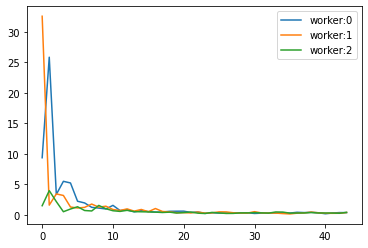

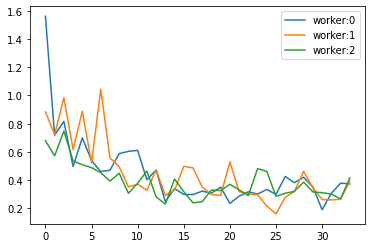

In [ ]:
for w in g.workers:
    plt.plot(w.trainlosslog, label= "worker:"+str(w.id))
plt.legend()
plt.show()
for w in g.workers:
    plt.plot(w.trainlosslog[10:], label= "worker:"+str(w.id))
plt.legend()
plt.show()

In [ ]:
for w in g.workers:
    print(w.trainlosslog)
print(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)))

[9.361915, 25.82321, 3.3548555, 5.4988227, 5.2296915, 2.236712, 1.9562292, 1.2373345, 1.1156898, 0.96925, 1.5613256, 0.71844864, 0.81651735, 0.49704275, 0.69930685, 0.53923917, 0.4598939, 0.470468, 0.5876738, 0.6036591, 0.61065716, 0.40280002, 0.47154015, 0.2464509, 0.33994582, 0.2985226, 0.29731286, 0.32188252, 0.3077779, 0.34933144, 0.23474224, 0.2864682, 0.31700706, 0.30096498, 0.333632, 0.29877603, 0.42615086, 0.3813367, 0.4205138, 0.3510786, 0.18966399, 0.30644915, 0.37798518, 0.37288553]
[32.5324, 1.6011593, 3.4329834, 3.1820955, 1.291966, 1.1274403, 1.2351742, 1.7754579, 1.267675, 1.424377, 0.8831006, 0.7227694, 0.9836644, 0.6171424, 0.8876983, 0.52087116, 1.0439413, 0.5574142, 0.49533328, 0.35169083, 0.37053847, 0.32763737, 0.47116867, 0.29192996, 0.3284424, 0.49755368, 0.4868941, 0.35056853, 0.29736218, 0.29172838, 0.52912295, 0.31862348, 0.3005936, 0.29671744, 0.2164464, 0.16032246, 0.27745715, 0.3203147, 0.46266675, 0.34397298, 0.26209542, 0.25950378, 0.2647186, 0.39167538]


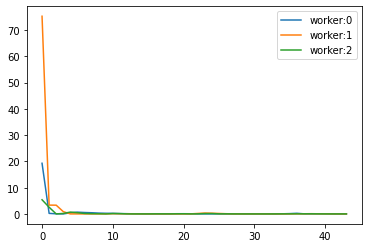

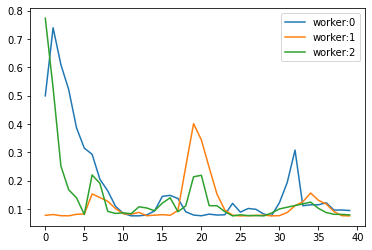

In [ ]:
for w in g.workers:
    plt.plot(w.validlosslog, label= "worker:"+str(w.id))
plt.legend()
plt.show()
for w in g.workers:
    plt.plot(w.validlosslog[4:], label= "worker:"+str(w.id))
plt.legend()
plt.show()

In [ ]:
for w in g.workers:
    print(w.validlosslog)
print(list(np.mean([w.validlosslog for w in g.workers], axis = 0)))

[19.327244, 0.28387755, 0.11922042, 0.07932132, 0.49972847, 0.73998225, 0.6096087, 0.5218539, 0.38693178, 0.31545222, 0.29357445, 0.20538573, 0.1648036, 0.11019791, 0.08525675, 0.076639436, 0.07662063, 0.07974079, 0.093934774, 0.14539514, 0.14885364, 0.13767697, 0.09093511, 0.07942012, 0.0768694, 0.082647264, 0.0793891, 0.0803879, 0.12056469, 0.08964548, 0.10260322, 0.099557646, 0.08274556, 0.07769296, 0.12288723, 0.19416514, 0.30839574, 0.11229842, 0.11556423, 0.11562309, 0.122584336, 0.09685125, 0.09723329, 0.09534797]
[75.21076, 3.421116, 3.3990057, 0.9422855, 0.078376725, 0.08124066, 0.07711479, 0.07674813, 0.08212619, 0.08315179, 0.15385334, 0.14113145, 0.12821567, 0.10207066, 0.08414888, 0.08230203, 0.08870883, 0.07693044, 0.07896615, 0.0807862, 0.07858514, 0.09562891, 0.25069237, 0.4018963, 0.34416828, 0.24698544, 0.15309863, 0.09721474, 0.07879688, 0.076358505, 0.077206604, 0.077983536, 0.07899719, 0.076512, 0.07721061, 0.08845027, 0.11234248, 0.12611638, 0.15723611, 0.13133205

In [ ]:
valid = [33.33051, 2.1059973, 1.1986066, 0.4262651, 0.45050916, 0.4496944, 0.31295428, 0.2557253, 0.20308037, 0.16009896, 0.22275442, 0.17917752, 0.1284861, 0.09911265, 0.08552337, 0.08106901, 0.09127879, 0.08700106, 0.089172654, 0.11585453, 0.12260565, 0.10809589, 0.1512103, 0.231929, 0.21353018, 0.14740461, 0.11487281, 0.08969563, 0.09191674, 0.08210216, 0.085708104, 0.08507732, 0.079396404, 0.0803008, 0.100338675, 0.12990718, 0.17791243, 0.11903173, 0.13263498, 0.1166533, 0.109628975, 0.09018698, 0.08536235, 0.08387043]
train = [14.465991, 10.465772, 2.9872532, 3.0666316, 2.4953334, 1.5661455, 1.303526, 1.2184547, 1.3118212, 1.1342725, 1.0411683, 0.67122704, 0.84937304, 0.5502165, 0.6984312, 0.51611465, 0.652013, 0.47372818, 0.5103819, 0.420629, 0.45293474, 0.3981843, 0.40823802, 0.2560468, 0.35883358, 0.37140527, 0.34095106, 0.3065754, 0.3114587, 0.32222736, 0.37803817, 0.3121472, 0.30234852, 0.3595208, 0.33743253, 0.248058, 0.33675385, 0.3407065, 0.42309463, 0.33704636, 0.254244, 0.28894413, 0.30321035, 0.39336205]

In [ ]:
from keras.models import load_model
for w in range(len(g.workers)):
    g.workers[w].model.save('model'+str(w)+'.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
g2 = Gossip()

In [ ]:
g2.main()

training worker:0
7.0839243
Validation Loss: 9.345168
training worker:1
15.934874
Validation Loss: 5.7343383
training worker:2
19.139462
Validation Loss: 5.578857
training worker:0
16.658562
Validation Loss: 2.3167913
training worker:1
42.8942
Validation Loss: 3.920182
training worker:2
41.61432
Validation Loss: 3.8790755
training worker:0
6.649418
Validation Loss: 1.9586562
training worker:1
34.87672
Validation Loss: 5.872089
training worker:2
8.52371
Validation Loss: 3.9706957
training worker:0
17.690502
Validation Loss: 2.044747
training worker:1
26.96494
Validation Loss: 0.23159231
training worker:2
22.341373
Validation Loss: 2.494835
training worker:0
14.355972
Validation Loss: 2.0548127
training worker:1
13.875114
Validation Loss: 0.13238364
training worker:2
19.965096
Validation Loss: 0.8178495
training worker:0
24.66248
Validation Loss: 2.0049353
training worker:1
7.959429
Validation Loss: 0.34473956
training worker:2
15.6766615
Validation Loss: 0.1609922
training worker:0
11.0

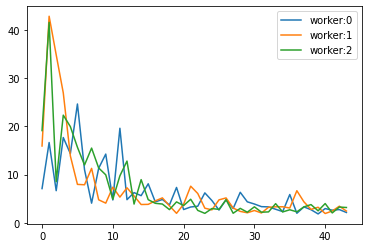

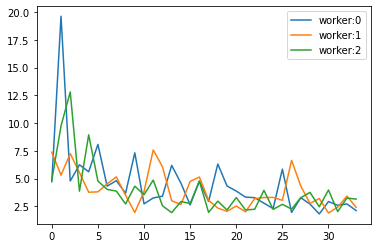

In [ ]:
for w in g2.workers:
    plt.plot(w.trainlosslog, label= "worker:"+str(w.id))
plt.legend()
plt.show()
for w in g2.workers:
    plt.plot(w.trainlosslog[10:], label= "worker:"+str(w.id))
plt.legend()
plt.show()

In [ ]:
for w in g2.workers:
    print(w.trainlosslog)
print(list(np.mean([w.trainlosslog for w in g2.workers], axis = 0)))

[7.0839243, 16.658562, 6.649418, 17.690502, 14.355972, 24.66248, 11.025656, 4.0567126, 11.30706, 14.252715, 4.7204223, 19.620512, 4.7851677, 6.246237, 5.6180677, 8.082064, 4.3235683, 4.818189, 3.6869345, 7.3227596, 2.7299175, 3.2620735, 3.4205563, 6.1913815, 4.5959115, 2.6283488, 4.766467, 2.9474669, 6.316829, 4.333683, 3.8818626, 3.3336225, 3.283652, 2.7906818, 2.303414, 5.853868, 1.9579386, 3.2821574, 2.7011173, 1.8227794, 2.9347441, 2.5974066, 2.7223897, 2.1227555]
[15.934874, 42.8942, 34.87672, 26.96494, 13.875114, 7.959429, 7.8773427, 11.286537, 4.7549257, 4.0626745, 7.3783913, 5.313771, 7.253406, 5.546049, 3.7761266, 3.8094845, 4.5332804, 5.154526, 3.5027785, 1.9473603, 3.8334732, 7.5826006, 6.0660543, 3.012425, 2.6656315, 4.74434, 5.144562, 3.0440893, 2.3477244, 2.0582297, 2.5332367, 2.0171838, 3.2049346, 3.2993321, 3.3084004, 3.046579, 6.64205, 4.326832, 2.7641606, 3.2111652, 1.9055996, 2.4271798, 3.4249628, 2.4168954]
[19.139462, 41.61432, 8.52371, 22.341373, 19.965096, 15.676

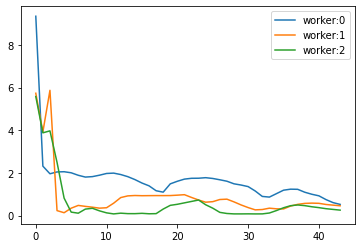

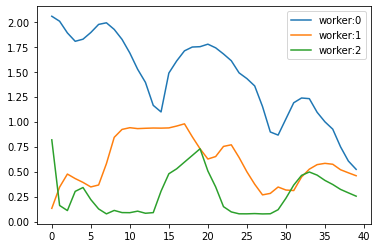

In [ ]:
for w in g2.workers:
    plt.plot(w.validlosslog, label= "worker:"+str(w.id))
plt.legend()
plt.show()
for w in g2.workers:
    plt.plot(w.validlosslog[4:], label= "worker:"+str(w.id))
plt.legend()
plt.show()

In [ ]:
for w in g2.workers:
    print(w.validlosslog)
print(list(np.mean([w.validlosslog for w in g2.workers], axis = 0)))

[9.345168, 2.3167913, 1.9586562, 2.044747, 2.0548127, 2.0049353, 1.8878703, 1.8041058, 1.8251675, 1.8921056, 1.9731113, 1.989223, 1.9229062, 1.8232079, 1.6868107, 1.5242927, 1.3928666, 1.1629343, 1.0970658, 1.4860635, 1.6072301, 1.7084973, 1.7466553, 1.7501724, 1.7752972, 1.7385334, 1.6773746, 1.609623, 1.4879298, 1.4308085, 1.3572758, 1.1514192, 0.89658046, 0.86545473, 1.0272653, 1.1890032, 1.2366465, 1.2300414, 1.0935932, 0.9980826, 0.92475456, 0.7478754, 0.60596836, 0.5223654]
[5.7343383, 3.920182, 5.872089, 0.23159231, 0.13238364, 0.34473956, 0.47539127, 0.43016082, 0.39198267, 0.3464844, 0.36603862, 0.57959706, 0.8427877, 0.92219543, 0.93941057, 0.93020666, 0.93358064, 0.9360521, 0.93497694, 0.9372034, 0.9557722, 0.9781332, 0.84870946, 0.7281181, 0.6258282, 0.65073687, 0.7520186, 0.76815814, 0.6411526, 0.4979974, 0.37362072, 0.26706937, 0.2819263, 0.3456616, 0.31559166, 0.31021264, 0.44576356, 0.52433944, 0.5697028, 0.5825686, 0.5734858, 0.51864684, 0.4879628, 0.4584877]
[5.578857

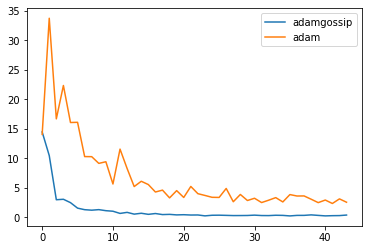

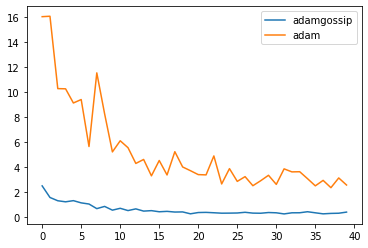

In [ ]:
plt.plot(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)), label = "adamgossip")
plt.plot(list(np.mean([w.trainlosslog for w in g2.workers], axis = 0)), label = "adam")
plt.legend()
plt.show()
plt.plot(list(np.mean([w.trainlosslog for w in g.workers], axis = 0))[4:], label = "adamgossip")
plt.plot(list(np.mean([w.trainlosslog for w in g2.workers], axis = 0))[4:], label = "adam")
plt.legend()
plt.show()

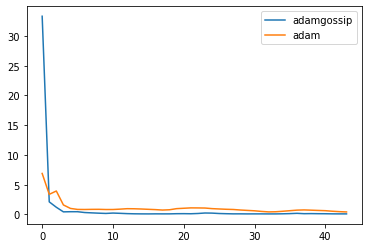

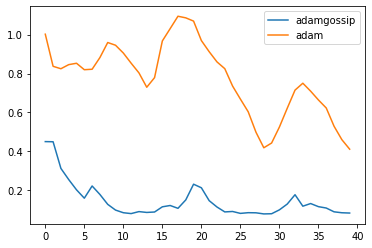

In [ ]:
plt.plot(list(np.mean([w.validlosslog for w in g.workers], axis = 0)), label = "adamgossip")
plt.plot(list(np.mean([w.validlosslog for w in g2.workers], axis = 0)), label = "adam")
plt.legend()
plt.show()
plt.plot(list(np.mean([w.validlosslog for w in g.workers], axis = 0))[4:], label = "adamgossip")
plt.plot(list(np.mean([w.validlosslog for w in g2.workers], axis = 0))[4:], label = "adam")
plt.legend()
plt.show()

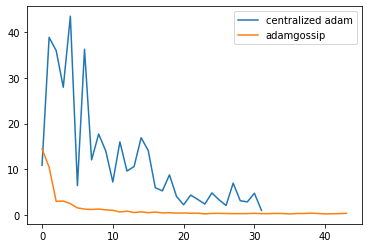

In [ ]:
training = [10.879026, 38.857952, 35.95152, 27.94555, 43.475765, 6.424527, 36.245346, 12.070671, 17.71987, 14.014793, 7.236498, 16.00698, 9.621456, 10.601118, 16.904438, 14.111562, 5.9833546, 5.2887177, 8.78121, 4.0684476, 2.252213, 4.36728, 3.409748, 2.4041257, 4.844544, 3.3319106, 2.095073, 6.979908, 3.1412117, 2.8743892, 4.7774315, 1.0056077]
training2 = [14.465991, 10.465772, 2.9872532, 3.0666316, 2.4953334, 1.5661455, 1.303526, 1.2184547, 1.3118212, 1.1342725, 1.0411683, 0.67122704, 0.84937304, 0.5502165, 0.6984312, 0.51611465, 0.652013, 0.47372818, 0.5103819, 0.420629, 0.45293474, 0.3981843, 0.40823802, 0.2560468, 0.35883358, 0.37140527, 0.34095106, 0.3065754, 0.3114587, 0.32222736, 0.37803817, 0.3121472, 0.30234852, 0.3595208, 0.33743253, 0.248058, 0.33675385, 0.3407065, 0.42309463, 0.33704636, 0.254244, 0.28894413, 0.30321035, 0.39336205]
plt.plot(training, label = "centralized adam")
plt.plot(training2, label = "adamgossip")
plt.legend()
plt.show()

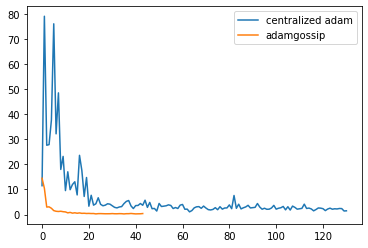

In [ ]:
plt.plot(c.learner.trainlosslog, label = "centralized adam")
plt.plot(training2, label = "adamgossip")
plt.legend()
plt.show()

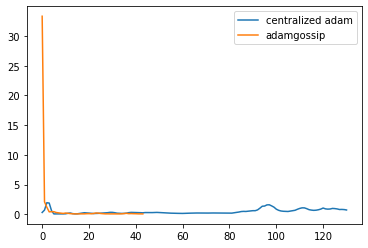

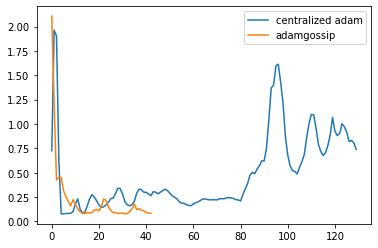

In [ ]:
valid = [33.33051, 2.1059973, 1.1986066, 0.4262651, 0.45050916, 0.4496944, 0.31295428, 0.2557253, 0.20308037, 0.16009896, 0.22275442, 0.17917752, 0.1284861, 0.09911265, 0.08552337, 0.08106901, 0.09127879, 0.08700106, 0.089172654, 0.11585453, 0.12260565, 0.10809589, 0.1512103, 0.231929, 0.21353018, 0.14740461, 0.11487281, 0.08969563, 0.09191674, 0.08210216, 0.085708104, 0.08507732, 0.079396404, 0.0803008, 0.100338675, 0.12990718, 0.17791243, 0.11903173, 0.13263498, 0.1166533, 0.109628975, 0.09018698, 0.08536235, 0.08387043]
plt.plot(c.learner.validlosslog, label = "centralized adam")
plt.plot(valid, label = "adamgossip")
plt.legend()
plt.show()
plt.plot(c.learner.validlosslog[1:], label = "centralized adam")
plt.plot(valid[1:], label = "adamgossip")
plt.legend()
plt.show()

#### fixed weights:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import queue    
class Worker():
    def __init__(self, M, p, img, label, X_train, Y_train, X_valid, Y_valid, id, batch_size = 32):
        self.batch_size = batch_size
        self.model = nvidia_model()
        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_train], np.array(label)[Y_train]))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        self.id = id
        # Prepare the validation dataset.
        val_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_valid], np.array(label)[Y_valid]))
        self.val_dataset = val_dataset.batch(batch_size)
        self.optimizer = Adam(learning_rate=1e-3)#keras.optimizers.SGD(learning_rate=1e-3)
        # Instantiate a loss function.
        self.loss_fn = keras.losses.MSE
        self.train_acc_metric = keras.metrics.RootMeanSquaredError()
        self.val_acc_metric = keras.metrics.RootMeanSquaredError()
        self.msgs = queue.Queue()
        self.alpha = 1/M
        self.M = M
        self.weights = self.model.get_weights()
        self.p = p
        self.trainlosslog = []
        self.validlosslog = []
    def get_msg(self,msg):
        self.msgs.put(msg)
    def send_msg(self,workerj):
        msg = {}
        self.alpha = self.alpha/2
        msg["alpha"] = self.alpha
        msg["weight"] = self.weights
        workerj.get_msg(msg)
    def update_weights(self, alphai, alphaj, w):
        weights = [w, self.weights]
        new_weights = list()
        relative_weights = np.array([1, 1])
        relative_weights = relative_weights/np.sum(relative_weights)
        for weights_list_tuple in zip(*weights): 
            new_weights.append(
                np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
            )   
        self.model.set_weights(new_weights)
        return
    def process(self):
        while True:
            if self.msgs.empty():
                break
            item = self.msgs.get()
            self.update_weights(self.alpha, item["alpha"], item["weight"])
            self.alpha = self.alpha + item["alpha"]
    def learn(self, workers, step, x_batch_train, y_batch_train, gossip = True):
        if gossip:
            self.process()
        self.step(x_batch_train, y_batch_train, step)
        if gossip and np.random.binomial(size=1, n=1, p= self.p):
            j = np.random.choice([i for i in range(len(workers)) if i!=self.id])
            self.send_msg(workers[j])
    def step(self, x_batch_train, y_batch_train, step):
        print("training worker:"+str(self.id))
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = self.model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.weights = self.model.get_weights()

        # Log every 200 batches.
        if True:#step % 200 == 0:
            print(np.mean(np.array(loss_value)))
            self.trainlosslog.append(np.mean(np.array(loss_value)))
        

        loss = []
        for x_batch_val, y_batch_val in self.val_dataset:
            val_logits = self.model(x_batch_val, training=False)
            # Update val metrics
            loss_value = self.loss_fn(y_batch_val, val_logits)
            loss.append(np.mean(loss_value))
        print("Validation Loss: "+str(np.mean(np.array(loss))))
        self.validlosslog.append(np.mean(np.array(loss)))
class Gossip():
    def __init__(self, worker_cnt = 3):
        self.worker_cnt = worker_cnt
        self.workers = [Worker(worker_cnt, 0.5, imgs[i], labels[i], X_train1, Y_train1, X_valid1, Y_valid1, i) for i in range(worker_cnt)]
        img = np.concatenate((np.array(imgs[0])[X_valid1], np.array(imgs[1])[X_valid1]), axis=0)
        img = np.concatenate((np.array(imgs[2])[X_valid1], img), axis=0)
        label = np.concatenate((np.array(labels[0])[Y_valid1], np.array(labels[1])[Y_valid1]), axis=0)
        label = np.concatenate((np.array(labels[2])[Y_valid1], label), axis=0)
        val_dataset = tf.data.Dataset.from_tensor_slices((img, label))
        self.val_dataset = val_dataset.batch(32)
        self.loss_fn = keras.losses.MSE
        self.model = nvidia_model()
        self.log = []
    def main(self, epoch = 1):
        for i in range(epoch):
            cntr = 0
            for batch in range(len(self.workers[0].train_dataset)):
                cntr += 1
                if cntr >14:
                    break
                weights = []
                for w in range(len(self.workers)):
                    for step, (x_batch_train, y_batch_train) in enumerate(self.workers[w].train_dataset):
                        if step!= batch:
                            continue
                        self.workers[w].learn( self.workers, batch, x_batch_train, y_batch_train)
                    weights.append(self.workers[w].weights)
                print("test")
                new_weights = list()
                relative_weights = np.array([1,1,1])
                relative_weights = relative_weights/np.sum(relative_weights)
                for weights_list_tuple in zip(*weights): 
                    new_weights.append(
                        np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
                    )   
                self.model.set_weights(new_weights)
                loss = []
                for x_batch_val, y_batch_val in self.val_dataset:
                    val_logits = self.model(x_batch_val, training=False)
                    # Update val metrics
                    loss_value = self.loss_fn(y_batch_val, val_logits)
                    loss.append(np.mean(loss_value))
                print("Validation Loss: "+str(np.mean(np.array(loss))))
                self.log.append(np.mean(np.array(loss))) 

In [ ]:
g = Gossip()

In [ ]:
g.main()

training worker:0
13.327022
Validation Loss: 39.684338
training worker:1
9.877588
Validation Loss: 2.1391234
training worker:2
1.6247665
Validation Loss: 0.8297838
test
Validation Loss: 0.3235476
training worker:0
13.859779
Validation Loss: 10.603504
training worker:1
24.043629
Validation Loss: 0.68732834
training worker:2
2.73805
Validation Loss: 1.2343272
test
Validation Loss: 0.08925336
training worker:0
22.011395
Validation Loss: 15.475656
training worker:1
0.7391692
Validation Loss: 0.09172411
training worker:2
5.311356
Validation Loss: 0.9858336
test
Validation Loss: 0.07698309
training worker:0
24.457447
Validation Loss: 5.492853
training worker:1
1.4806361
Validation Loss: 0.36953524
training worker:2
5.5810595
Validation Loss: 0.16576833
test
Validation Loss: 0.07696334
training worker:0
10.004047
Validation Loss: 0.46761993
training worker:1
1.7772986
Validation Loss: 0.14909774
training worker:2
5.9906836
Validation Loss: 0.38193294
test
Validation Loss: 0.43983227
training 

In [ ]:
for w in g.workers:
    print(w.trainlosslog)
print(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)))

[13.327022, 13.859779, 22.011395, 24.457447, 10.004047, 4.624546, 7.2969913, 3.0530477, 3.656804, 3.8078778, 2.2473817, 2.2183402, 1.9949832, 1.9323773]
[9.877588, 24.043629, 0.7391692, 1.4806361, 1.7772986, 1.2172546, 3.2743964, 3.0393472, 2.6637228, 3.0724444, 2.5519533, 1.9050174, 1.0847753, 1.8703483]
[1.6247665, 2.73805, 5.311356, 5.5810595, 5.9906836, 5.946704, 4.808247, 4.568747, 2.9663286, 2.7237582, 3.1423645, 3.0041258, 3.5734806, 2.0629892]
[8.276459, 13.5471525, 9.353973, 10.506381, 5.92401, 3.9295015, 5.126545, 3.553714, 3.0956185, 3.20136, 2.6472332, 2.3758278, 2.2177465, 1.9552383]


In [ ]:
for w in g.workers:
    print(w.validlosslog)
print(list(np.mean([w.validlosslog for w in g.workers], axis = 0)))

[39.684338, 10.603504, 15.475656, 5.492853, 0.46761993, 1.2547336, 1.3925556, 2.1893396, 2.125088, 1.9124123, 1.4522152, 1.2805568, 1.1360172, 0.62630725]
[2.1391234, 0.68732834, 0.09172411, 0.36953524, 0.14909774, 0.07732798, 0.6363146, 0.72096926, 1.5046704, 1.3829821, 0.42778322, 0.21217056, 0.09931987, 0.14528541]
[0.8297838, 1.2343272, 0.9858336, 0.16576833, 0.38193294, 1.7901306, 2.6687748, 2.3715868, 1.462672, 0.8704378, 0.8192623, 0.43864557, 0.50503874, 0.35686654]
[14.217748, 4.175053, 5.517738, 2.0093856, 0.33288357, 1.0407307, 1.5658817, 1.7606319, 1.6974767, 1.3886107, 0.8997536, 0.643791, 0.5801253, 0.37615308]


In [ ]:
list(g.log)

[0.3235476,
 0.08925336,
 0.07698309,
 0.07696334,
 0.43983227,
 1.4891659,
 1.9358213,
 2.2540152,
 1.9761193,
 1.5040835,
 0.9549771,
 0.69605786,
 0.4781362,
 0.23694783]

In [ ]:
train2 = [8.276459, 13.5471525, 9.353973, 10.506381, 5.92401, 3.9295015, 5.126545, 3.553714, 3.0956185, 3.20136, 2.6472332, 2.3758278, 2.2177465, 1.9552383]
valid2 = [14.217748, 4.175053, 5.517738, 2.0093856, 0.33288357, 1.0407307, 1.5658817, 1.7606319, 1.6974767, 1.3886107, 0.8997536, 0.643791, 0.5801253, 0.37615308]
validlog2 = [0.3235476,
 0.08925336,
 0.07698309,
 0.07696334,
 0.43983227,
 1.4891659,
 1.9358213,
 2.2540152,
 1.9761193,
 1.5040835,
 0.9549771,
 0.69605786,
 0.4781362,
 0.23694783]

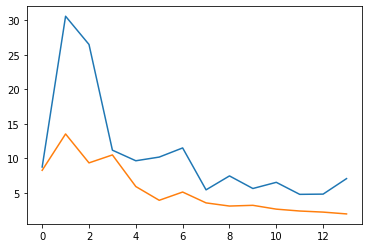

In [ ]:
plt.plot(train1, label = "changing w")
plt.plot(train2, label = "fixed w")

In [ ]:
g.main()

training worker:0
11.477758
Validation Loss: 1.2835937
training worker:1
47.660183
Validation Loss: 62.29646
training worker:2
21.89701
Validation Loss: 0.31573543
training worker:0
21.025532
Validation Loss: 0.15028113
training worker:1
161.2973
Validation Loss: 22.464766
training worker:2
27.22352
Validation Loss: 7.3960156
training worker:0
17.452486
Validation Loss: 0.75034577
training worker:1
67.648026
Validation Loss: 1.3588084
training worker:2
2.0816457
Validation Loss: 0.08185788
training worker:0
15.719734
Validation Loss: 0.49875385
training worker:1
2.9859319
Validation Loss: 1.1072843
training worker:2
0.9616632
Validation Loss: 0.15669914
training worker:0
28.000134
Validation Loss: 0.23661818
training worker:1
4.561022
Validation Loss: 0.89681345
training worker:2
3.8623464
Validation Loss: 0.3231098
training worker:0
21.293116
Validation Loss: 0.07662411
training worker:1
4.359768
Validation Loss: 0.9302574
training worker:2
2.9784002
Validation Loss: 0.4296959
trainin

In [ ]:
for w in g.workers:
    print(w.trainlosslog)
print(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)))

[11.477758, 21.025532, 17.452486, 15.719734, 28.000134, 21.293116, 8.811581, 8.7390175, 12.903552, 9.553942, 5.6274347, 5.6384296, 1.97466, 0.92921627, 1.4319744, 1.7073419, 1.3474126, 1.1504747, 0.792711, 0.7831327, 0.8830066, 1.0160444, 1.2689484, 1.2177837, 0.706272, 1.1549832, 0.6119026, 1.0462005, 0.5696218, 1.1459984, 0.806758, 0.9450586, 0.5522542, 0.63294756, 1.0129544, 0.8765079, 0.77780676, 0.7539258, 1.1872149, 0.7582495, 0.62879896, 0.5938699, 0.58781964, 0.98481214]
[47.660183, 161.2973, 67.648026, 2.9859319, 4.561022, 4.359768, 0.5021634, 0.4986735, 0.5182785, 0.8774928, 0.9439332, 0.71017176, 0.6164105, 0.6329767, 0.7227287, 1.1896783, 1.0293847, 1.4342194, 0.9728167, 1.0785823, 0.5953163, 0.77272767, 0.9881407, 0.8383937, 0.79967684, 0.5384171, 0.82176113, 0.9802834, 0.8092327, 0.5358313, 0.5886498, 0.58711463, 0.63916105, 0.6745423, 1.1601374, 0.6949581, 0.9302183, 1.0875034, 0.6140772, 0.71649945, 0.7676798, 0.75519496, 0.9807874, 0.67470783]
[21.89701, 27.22352, 2.08

In [ ]:
for w in g.workers:
    print(w.validlosslog)
print(list(np.mean([w.validlosslog for w in g.workers], axis = 0)))

[1.2835937, 0.15028113, 0.75034577, 0.49875385, 0.23661818, 0.07662411, 0.12838167, 0.078531794, 0.19189404, 0.5684037, 0.7678621, 0.8040995, 0.7164347, 0.709888, 0.70074296, 0.69080365, 0.6910189, 0.46538028, 0.34563747, 0.33645898, 0.29627, 0.3177818, 0.33553794, 0.35918698, 0.41776812, 0.42734674, 0.31575567, 0.2865139, 0.15754186, 0.19706732, 0.2027492, 0.17368363, 0.119631775, 0.20003082, 0.19637805, 0.20297657, 0.17796414, 0.16170649, 0.15009409, 0.09455118, 0.07640928, 0.080122024, 0.07712911, 0.07636332]
[62.29646, 22.464766, 1.3588084, 1.1072843, 0.89681345, 0.9302574, 0.08081684, 0.07649805, 0.07639425, 0.079423994, 0.16565862, 0.10549298, 0.13164012, 0.15672733, 0.16328369, 0.16562147, 0.36116257, 0.35801896, 0.37765038, 0.28311536, 0.33166736, 0.34594062, 0.20628951, 0.23343602, 0.31008586, 0.33524582, 0.21564601, 0.2728705, 0.23781611, 0.19971676, 0.14696154, 0.123143286, 0.2813461, 0.2562314, 0.23991615, 0.23280653, 0.18820764, 0.19251919, 0.169091, 0.14484547, 0.11879325

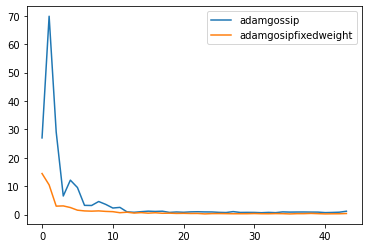

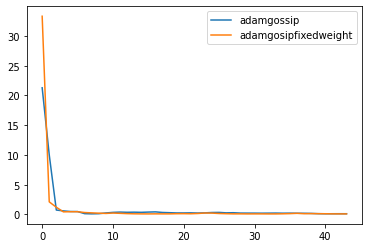

In [ ]:
plt.plot(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)), label = "adamgossip")
plt.plot(train, label = "adamgosipfixedweight")
plt.legend()
plt.show()
plt.plot(list(np.mean([w.validlosslog for w in g.workers], axis = 0)), label = "adamgossip")
plt.plot(valid, label = "adamgosipfixedweight")
plt.legend()
plt.show()

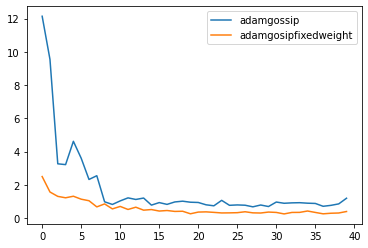

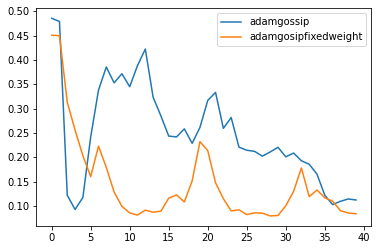

In [ ]:
plt.plot(list(np.mean([w.trainlosslog for w in g.workers], axis = 0))[4:], label = "adamgossip")
plt.plot(train[4:], label = "adamgosipfixedweight")
plt.legend()
plt.show()
plt.plot(list(np.mean([w.validlosslog for w in g.workers], axis = 0))[4:], label = "adamgossip")
plt.plot(valid[4:], label = "adamgosipfixedweight")
plt.legend()
plt.show()

#### random weight

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import queue    
class Worker():
    def __init__(self, M, p, img, label, X_train, Y_train, X_valid, Y_valid, id, batch_size = 32):
        self.batch_size = batch_size
        self.model = nvidia_model()
        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_train], np.array(label)[Y_train]))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        self.id = id
        # Prepare the validation dataset.
        val_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_valid], np.array(label)[Y_valid]))
        self.val_dataset = val_dataset.batch(batch_size)
        self.optimizer = Adam(learning_rate=1e-3)#keras.optimizers.SGD(learning_rate=1e-3)
        # Instantiate a loss function.
        self.loss_fn = keras.losses.MSE
        self.train_acc_metric = keras.metrics.RootMeanSquaredError()
        self.val_acc_metric = keras.metrics.RootMeanSquaredError()
        self.msgs = queue.Queue()
        self.alpha = 1/M
        self.M = M
        self.weights = self.model.get_weights()
        self.p = p
        self.trainlosslog = []
        self.validlosslog = []
        self.w = np.random.rand(3,3)
    def get_msg(self,msg):
        self.msgs.put(msg)
    def send_msg(self,workerj):
        msg = {}
        self.alpha = self.alpha/2
        msg["alpha"] = self.w[self.id][workerj.id]
        msg["weight"] = self.weights
        workerj.get_msg(msg)
    def update_weights(self, alphai, alphaj, w):
        weights = [w, self.weights]
        new_weights = list()
        relative_weights = np.array([alphaj, alphai])
        relative_weights = relative_weights/np.sum(relative_weights)
        for weights_list_tuple in zip(*weights): 
            new_weights.append(
                np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
            )   
        self.model.set_weights(new_weights)
        return
    def process(self):
        while True:
            if self.msgs.empty():
                break
            item = self.msgs.get()
            self.update_weights(self.alpha, item["alpha"], item["weight"])
            self.alpha = self.alpha + item["alpha"]
    def learn(self, workers, step, x_batch_train, y_batch_train, gossip = True):
        if gossip:
            self.process()
        self.step(x_batch_train, y_batch_train, step)
        if gossip and np.random.binomial(size=1, n=1, p= self.p):
            j = np.random.choice([i for i in range(len(workers)) if i!=self.id])
            self.send_msg(workers[j])
    def step(self, x_batch_train, y_batch_train, step):
        print("training worker:"+str(self.id))
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = self.model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.weights = self.model.get_weights()

        # Log every 200 batches.
        if True:#step % 200 == 0:
            print(np.mean(np.array(loss_value)))
            self.trainlosslog.append(np.mean(np.array(loss_value)))
        

        loss = []
        for x_batch_val, y_batch_val in self.val_dataset:
            val_logits = self.model(x_batch_val, training=False)
            # Update val metrics
            loss_value = self.loss_fn(y_batch_val, val_logits)
            loss.append(np.mean(loss_value))
        print("Validation Loss: "+str(np.mean(np.array(loss))))
        self.validlosslog.append(np.mean(np.array(loss)))
class Gossip():
    def __init__(self, worker_cnt = 3):
        self.worker_cnt = worker_cnt
        self.workers = [Worker(worker_cnt, 0.5, imgs[i], labels[i], X_train1, Y_train1, X_valid1, Y_valid1, i) for i in range(worker_cnt)]
        img = np.concatenate((np.array(imgs[0])[X_valid1], np.array(imgs[1])[X_valid1]), axis=0)
        img = np.concatenate((np.array(imgs[2])[X_valid1], img), axis=0)
        label = np.concatenate((np.array(labels[0])[Y_valid1], np.array(labels[1])[Y_valid1]), axis=0)
        label = np.concatenate((np.array(labels[2])[Y_valid1], label), axis=0)
        val_dataset = tf.data.Dataset.from_tensor_slices((img, label))
        self.val_dataset = val_dataset.batch(32)
        self.loss_fn = keras.losses.MSE
        self.model = nvidia_model()
        self.log = []
    def main(self, epoch = 1):
        for i in range(epoch):
            cntr = 0
            for batch in range(len(self.workers[0].train_dataset)):
                cntr += 1
                if cntr >14:
                    break
                weights = []
                for w in range(len(self.workers)):
                    for step, (x_batch_train, y_batch_train) in enumerate(self.workers[w].train_dataset):
                        if step!= batch:
                            continue
                        self.workers[w].learn( self.workers, batch, x_batch_train, y_batch_train)
                    weights.append(self.workers[w].weights)
                print("test")
                new_weights = list()
                relative_weights = np.array([1,1,1])
                relative_weights = relative_weights/np.sum(relative_weights)
                for weights_list_tuple in zip(*weights): 
                    new_weights.append(
                        np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
                    )   
                self.model.set_weights(new_weights)
                loss = []
                for x_batch_val, y_batch_val in self.val_dataset:
                    val_logits = self.model(x_batch_val, training=False)
                    # Update val metrics
                    loss_value = self.loss_fn(y_batch_val, val_logits)
                    loss.append(np.mean(loss_value))
                print("Validation Loss: "+str(np.mean(np.array(loss))))
                self.log.append(np.mean(np.array(loss)))

In [ ]:
g = Gossip()

In [ ]:
g.main()

training worker:0
9.792991
Validation Loss: 5.9535527
training worker:1
3.594136
Validation Loss: 3.799005
training worker:2
10.198305
Validation Loss: 0.690026
test
Validation Loss: 1.3558556
training worker:0
33.198826
Validation Loss: 14.6582
training worker:1
4.2370005
Validation Loss: 0.12566887
training worker:2
11.080491
Validation Loss: 0.07640138
test
Validation Loss: 0.44485152
training worker:0
12.902761
Validation Loss: 0.083239
training worker:1
7.236495
Validation Loss: 0.5580528
training worker:2
55.66234
Validation Loss: 9.916256
test
Validation Loss: 0.4307393
training worker:0
3.6295524
Validation Loss: 0.11546967
training worker:1
1.9868283
Validation Loss: 0.08260857
training worker:2
5.463283
Validation Loss: 0.40568116
test
Validation Loss: 0.41301808
training worker:0
3.050498
Validation Loss: 0.49204704
training worker:1
1.9168227
Validation Loss: 0.0921745
training worker:2
2.0853386
Validation Loss: 0.9755329
test
Validation Loss: 0.8818152
training worker:0
1

In [ ]:
for w in g.workers:
    print(w.trainlosslog)
print(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)))

[9.792991, 33.198826, 12.902761, 3.6295524, 3.050498, 1.4767336, 2.3926458, 2.526605, 1.724376, 2.29028, 2.269741, 2.0152626, 1.3218398, 1.5292661]
[3.594136, 4.2370005, 7.236495, 1.9868283, 1.9168227, 1.2376714, 1.741499, 2.1117759, 2.2275426, 2.091978, 3.058369, 1.7459669, 1.4293337, 1.4540259]
[10.198305, 11.080491, 55.66234, 5.463283, 2.0853386, 3.463416, 6.2854123, 4.1570177, 3.292801, 3.455241, 3.5667887, 2.2982352, 2.1737363, 1.757111]
[7.8618107, 16.172106, 25.267197, 3.6932213, 2.3508863, 2.0592737, 3.4731858, 2.9317997, 2.4149065, 2.6125, 2.964966, 2.0198214, 1.6416365, 1.5801344]


In [ ]:
for w in g.workers:
    print(w.validlosslog)
print(list(np.mean([w.validlosslog for w in g.workers], axis = 0)))

[5.9535527, 14.6582, 0.083239, 0.11546967, 0.49204704, 0.42462635, 0.77348655, 1.2142602, 1.0509284, 0.41084328, 0.3333438, 0.27683547, 0.18615144, 0.16838981]
[3.799005, 0.12566887, 0.5580528, 0.08260857, 0.0921745, 0.10760407, 0.19975753, 0.6892614, 0.56661916, 0.1377217, 0.45801213, 0.45637313, 0.28111473, 0.2572323]
[0.690026, 0.07640138, 9.916256, 0.40568116, 0.9755329, 1.1068299, 1.1642423, 1.046726, 0.72591853, 0.52506447, 0.43580484, 0.20240726, 0.17144702, 0.14821865]
[3.4808614, 4.9534235, 3.5191824, 0.20125313, 0.51991814, 0.5463534, 0.7124955, 0.98341584, 0.78115535, 0.35787645, 0.4090536, 0.31187195, 0.2129044, 0.19128025]


In [ ]:
list(g.log)

[1.3558556,
 0.44485152,
 0.4307393,
 0.41301808,
 0.8818152,
 1.1690145,
 1.1594741,
 0.8964286,
 0.4318127,
 0.2007711,
 0.28363538,
 0.31554618,
 0.1993671,
 0.1795348]

In [ ]:
train3 = [7.8618107, 16.172106, 25.267197, 3.6932213, 2.3508863, 2.0592737, 3.4731858, 2.9317997, 2.4149065, 2.6125, 2.964966, 2.0198214, 1.6416365, 1.5801344]
valid3 = [3.4808614, 4.9534235, 3.5191824, 0.20125313, 0.51991814, 0.5463534, 0.7124955, 0.98341584, 0.78115535, 0.35787645, 0.4090536, 0.31187195, 0.2129044, 0.19128025]
validlog3 = [1.3558556,
 0.44485152,
 0.4307393,
 0.41301808,
 0.8818152,
 1.1690145,
 1.1594741,
 0.8964286,
 0.4318127,
 0.2007711,
 0.28363538,
 0.31554618,
 0.1993671,
 0.1795348]

In [ ]:
g.main()

training worker:0
21.568872
Validation Loss: 0.5084899
training worker:1
15.300089
Validation Loss: 2.6141722
training worker:2
19.859083
Validation Loss: 4.213257
training worker:0
45.490105
Validation Loss: 3.9669068
training worker:1
3.4023871
Validation Loss: 1.5094148
training worker:2
40.60363
Validation Loss: 0.07722957
training worker:0
5.243597
Validation Loss: 4.118628
training worker:1
4.989073
Validation Loss: 1.6312579
training worker:2
46.540836
Validation Loss: 0.25966737
training worker:0
18.620872
Validation Loss: 0.6222225
training worker:1
3.1597743
Validation Loss: 2.363747
training worker:2
17.387197
Validation Loss: 0.91902834
training worker:0
18.441631
Validation Loss: 0.12643085
training worker:1
2.0575752
Validation Loss: 0.3585232
training worker:2
29.174076
Validation Loss: 0.68945736
training worker:0
7.2560406
Validation Loss: 0.09026459
training worker:1
1.9518031
Validation Loss: 0.52481604
training worker:2
11.053003
Validation Loss: 0.44968006
training

In [ ]:
for w in g.workers:
    print(w.trainlosslog)
print(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)))

[21.568872, 45.490105, 5.243597, 18.620872, 18.441631, 7.2560406, 8.260014, 6.9218836, 4.61112, 4.3073974, 2.7943316, 3.618775, 4.9655285, 1.8693074, 1.4378576, 1.1903727, 1.5274807, 2.2347069, 2.081574, 2.5900378, 0.8546039, 1.6592934, 1.4207124, 1.1950159, 2.1215005, 1.7119429, 0.71808326, 1.6564138, 2.048781, 1.5899577, 1.8098128, 1.0967332, 1.1496978, 1.1022143, 1.5499065, 1.119647, 0.7667291, 0.8809045, 0.84181094, 1.8858052, 0.77137256, 0.9681668, 0.82352954, 1.3768747]
[15.300089, 3.4023871, 4.989073, 3.1597743, 2.0575752, 1.9518031, 1.5366848, 2.4507089, 2.7379777, 4.752711, 1.5532107, 1.6916976, 2.49195, 1.7847649, 1.3585391, 1.9919847, 2.8590388, 1.8526286, 1.8959615, 2.1347528, 1.3895459, 1.012182, 1.2171822, 2.1026583, 1.9120932, 1.0149866, 1.1332495, 1.643286, 1.7869884, 2.1065083, 1.1312487, 1.0695627, 1.8704727, 1.2664751, 1.0111897, 1.1296954, 1.1401622, 1.2627637, 0.72951, 1.1692384, 1.3328637, 1.3246101, 1.6519146, 1.0345396]
[19.859083, 40.60363, 46.540836, 17.387197

In [ ]:
for w in g.workers:
    print(w.validlosslog)
print(list(np.mean([w.validlosslog for w in g.workers], axis = 0)))

[0.5084899, 3.9669068, 4.118628, 0.6222225, 0.12643085, 0.09026459, 0.086926036, 0.38832638, 1.0327218, 0.8438034, 0.39896515, 0.10143364, 0.19240044, 0.13896686, 0.09781177, 0.5863683, 0.99589103, 0.99684215, 1.365663, 0.3231041, 0.15064615, 0.18298508, 1.1029918, 1.6892724, 1.9130114, 1.6739978, 1.4539235, 0.1725618, 0.07636608, 0.0831215, 0.08160824, 0.07683158, 0.0815715, 0.1033328, 0.09384527, 0.09514894, 0.088274434, 0.07831721, 0.07732438, 0.076561205, 0.08617891, 0.094971865, 0.08057299, 0.090623684]
[2.6141722, 1.5094148, 1.6312579, 2.363747, 0.3585232, 0.52481604, 0.5331984, 0.3354004, 0.25491112, 0.47462508, 1.4078097, 0.5053226, 0.60363173, 0.07795786, 0.13235787, 0.07658145, 0.2840141, 0.3651127, 0.08563411, 0.47339246, 1.3321515, 1.4958661, 1.0427483, 0.61350155, 0.49081194, 0.3132718, 0.08011916, 0.18181983, 0.45154256, 0.23290478, 0.1693528, 0.07642856, 0.24336411, 0.49744228, 0.63165754, 0.09235566, 0.08905319, 0.087507725, 0.11900423, 0.13450947, 0.19114408, 0.2075141

random double

In [ ]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import queue    
class Worker():
    def __init__(self, M, p, img, label, X_train, Y_train, X_valid, Y_valid, id, batch_size = 32):
        self.batch_size = batch_size
        self.model = nvidia_model()
        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_train], np.array(label)[Y_train]))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        self.id = id
        # Prepare the validation dataset.
        val_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_valid], np.array(label)[Y_valid]))
        self.val_dataset = val_dataset.batch(batch_size)
        self.optimizer = Adam(learning_rate=1e-3)#keras.optimizers.SGD(learning_rate=1e-3)
        # Instantiate a loss function.
        self.loss_fn = keras.losses.MSE
        self.train_acc_metric = keras.metrics.RootMeanSquaredError()
        self.val_acc_metric = keras.metrics.RootMeanSquaredError()
        self.msgs = queue.Queue()
        self.alpha = 1/M
        self.M = M
        self.weights = self.model.get_weights()
        self.p = p
        self.trainlosslog = []
        self.validlosslog = []
        self.w = dp
    def get_msg(self,msg):
        self.msgs.put(msg)
    def send_msg(self,workerj):
        msg = {}
        self.alpha = self.alpha/2
        msg["alpha"] = self.w[self.id][workerj.id]
        msg["weight"] = self.weights
        workerj.get_msg(msg)
    def update_weights(self, alphai, alphaj, w):
        weights = [w, self.weights]
        new_weights = list()
        relative_weights = np.array([alphaj, alphai])
        relative_weights = relative_weights/np.sum(relative_weights)
        for weights_list_tuple in zip(*weights): 
            new_weights.append(
                np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
            )   
        self.model.set_weights(new_weights)
        return
    def process(self):
        while True:
            if self.msgs.empty():
                break
            item = self.msgs.get()
            self.update_weights(self.alpha, item["alpha"], item["weight"])
            self.alpha = self.alpha + item["alpha"]
    def learn(self, workers, step, x_batch_train, y_batch_train, gossip = True):
        if gossip:
            self.process()
        self.step(x_batch_train, y_batch_train, step)
        if gossip and np.random.binomial(size=1, n=1, p= self.p):
            j = np.random.choice([i for i in range(len(workers)) if i!=self.id])
            self.send_msg(workers[j])
    def step(self, x_batch_train, y_batch_train, step):
        print("training worker:"+str(self.id))
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = self.model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.weights = self.model.get_weights()

        # Log every 200 batches.
        if True:#step % 200 == 0:
            print(np.mean(np.array(loss_value)))
            self.trainlosslog.append(np.mean(np.array(loss_value)))
        

        loss = []
        for x_batch_val, y_batch_val in self.val_dataset:
            val_logits = self.model(x_batch_val, training=False)
            # Update val metrics
            loss_value = self.loss_fn(y_batch_val, val_logits)
            loss.append(np.mean(loss_value))
        print("Validation Loss: "+str(np.mean(np.array(loss))))
        self.validlosslog.append(np.mean(np.array(loss)))
class Gossip():
    def __init__(self, worker_cnt = 3):
        self.worker_cnt = worker_cnt
        self.workers = [Worker(worker_cnt, 0.5, imgs[i], labels[i], X_train1, Y_train1, X_valid1, Y_valid1, i) for i in range(worker_cnt)]
        img = np.concatenate((np.array(imgs[0])[X_valid1], np.array(imgs[1])[X_valid1]), axis=0)
        img = np.concatenate((np.array(imgs[2])[X_valid1], img), axis=0)
        label = np.concatenate((np.array(labels[0])[Y_valid1], np.array(labels[1])[Y_valid1]), axis=0)
        label = np.concatenate((np.array(labels[2])[Y_valid1], label), axis=0)
        val_dataset = tf.data.Dataset.from_tensor_slices((img, label))
        self.val_dataset = val_dataset.batch(32)
        self.loss_fn = keras.losses.MSE
        self.model = nvidia_model()
        self.log = []
    def main(self, epoch = 1):
        for i in range(epoch):
            cntr = 0
            for batch in range(len(self.workers[0].train_dataset)):
                cntr += 1
                if cntr >14:
                    break
                weights = []
                for w in range(len(self.workers)):
                    for step, (x_batch_train, y_batch_train) in enumerate(self.workers[w].train_dataset):
                        if step!= batch:
                            continue
                        self.workers[w].learn( self.workers, batch, x_batch_train, y_batch_train)
                    weights.append(self.workers[w].weights)
                print("test")
                new_weights = list()
                relative_weights = np.array([1,1,1])
                relative_weights = relative_weights/np.sum(relative_weights)
                for weights_list_tuple in zip(*weights): 
                    new_weights.append(
                        np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
                    )   
                self.model.set_weights(new_weights)
                loss = []
                for x_batch_val, y_batch_val in self.val_dataset:
                    val_logits = self.model(x_batch_val, training=False)
                    # Update val metrics
                    loss_value = self.loss_fn(y_batch_val, val_logits)
                    loss.append(np.mean(loss_value))
                print("Validation Loss: "+str(np.mean(np.array(loss))))
                self.log.append(np.mean(np.array(loss)))    

row = 3
r = [1,1,1]
column = 3
c = [1,1,1]
dp = np.zeros((row, column))
dp[0][0] = random.random()
r[0] -= dp[0][0]
c[0] -= dp[0][0]
for i in range(row):
    for j in range(column):
        if i == 0 and j == 0:
            continue
        dp[i][j] = np.min([r[i], c[j]])
        r[i] -= dp[i][j]
        c[j] -= dp[i][j]

In [ ]:
g = Gossip()

In [ ]:
g.main()

training worker:0
5.682132
Validation Loss: 2.248873
training worker:1
18.386076
Validation Loss: 1.6461891
training worker:2
17.870186
Validation Loss: 5.150784
test
Validation Loss: 0.6319077
training worker:0
13.320721
Validation Loss: 0.84835243
training worker:1
17.947203
Validation Loss: 5.1814055
training worker:2
17.122602
Validation Loss: 0.36343142
test
Validation Loss: 0.9278061
training worker:0
8.045734
Validation Loss: 0.12094045
training worker:1
1.162529
Validation Loss: 0.44150198
training worker:2
17.306581
Validation Loss: 0.7510166
test
Validation Loss: 0.12274887
training worker:0
6.5322084
Validation Loss: 0.09421296
training worker:1
1.0471581
Validation Loss: 0.6224873
training worker:2
16.556946
Validation Loss: 0.8166828
test
Validation Loss: 0.09231608
training worker:0
8.824797
Validation Loss: 0.09868691
training worker:1
1.1974759
Validation Loss: 0.7434903
training worker:2
9.691116
Validation Loss: 0.6820528
test
Validation Loss: 0.08910532
training work

In [ ]:
for w in g.workers:
    print(w.trainlosslog)
print(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)))

[5.682132, 13.320721, 8.045734, 6.5322084, 8.824797, 21.765362, 7.910216, 2.063191, 1.5650203, 1.1001585, 1.7872593, 0.95503765, 0.69572556, 1.0194495]
[18.386076, 17.947203, 1.162529, 1.0471581, 1.1974759, 2.4201515, 1.4205328, 2.6328924, 1.2339635, 2.7028103, 1.12305, 1.8571169, 1.1756403, 1.1524096]
[17.870186, 17.122602, 17.306581, 16.556946, 9.691116, 19.991259, 8.62348, 11.560825, 26.101095, 13.903236, 3.6312194, 13.134705, 9.830242, 13.011026]
[13.979465, 16.130175, 8.838282, 8.045438, 6.5711293, 14.725591, 5.9847426, 5.4189696, 9.63336, 5.9020686, 2.1805096, 5.31562, 3.9005358, 5.0609617]


In [ ]:
for w in g.workers:
    print(w.validlosslog)
print(list(np.mean([w.validlosslog for w in g.workers], axis = 0)))

[2.248873, 0.84835243, 0.12094045, 0.09421296, 0.09868691, 0.0772264, 0.5520306, 0.17130145, 0.18778823, 0.22849745, 0.28045857, 0.16528596, 0.16728222, 0.17803991]
[1.6461891, 5.1814055, 0.44150198, 0.6224873, 0.7434903, 0.12854391, 0.15153232, 0.15480131, 0.16237865, 0.15877433, 0.14911664, 0.12621653, 0.14833508, 0.1453405]
[5.150784, 0.36343142, 0.7510166, 0.8166828, 0.6820528, 0.46412706, 0.53031963, 0.56144357, 0.59328085, 0.64998907, 0.68183154, 0.6450424, 0.54711175, 0.46051624]
[3.015282, 2.1310632, 0.4378197, 0.5111277, 0.50807667, 0.22329913, 0.41129422, 0.29584876, 0.31448257, 0.34575358, 0.37046894, 0.31218162, 0.28757635, 0.2612989]


In [ ]:
list(g.log)

[0.6319077,
 0.9278061,
 0.12274887,
 0.09231608,
 0.08910532,
 0.08680935,
 0.092131205,
 0.104054056,
 0.07839022,
 0.07644733,
 0.07645033,
 0.0766305,
 0.078127526,
 0.07873457]

In [ ]:
train4 = [13.979465, 16.130175, 8.838282, 8.045438, 6.5711293, 14.725591, 5.9847426, 5.4189696, 9.63336, 5.9020686, 2.1805096, 5.31562, 3.9005358, 5.0609617]
valid4 = [3.015282, 2.1310632, 0.4378197, 0.5111277, 0.50807667, 0.22329913, 0.41129422, 0.29584876, 0.31448257, 0.34575358, 0.37046894, 0.31218162, 0.28757635, 0.2612989]
validlog4 = [0.6319077,
 0.9278061,
 0.12274887,
 0.09231608,
 0.08910532,
 0.08680935,
 0.092131205,
 0.104054056,
 0.07839022,
 0.07644733,
 0.07645033,
 0.0766305,
 0.078127526,
 0.07873457]


#### Fully connected

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import queue    
class Worker():
    def __init__(self, M, p, img, label, X_train, Y_train, X_valid, Y_valid, id, batch_size = 32):
        self.batch_size = batch_size
        self.model = nvidia_model()
        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_train], np.array(label)[Y_train]))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        self.id = id
        # Prepare the validation dataset.
        val_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_valid], np.array(label)[Y_valid]))
        self.val_dataset = val_dataset.batch(batch_size)
        self.optimizer = Adam(learning_rate=1e-3)#keras.optimizers.SGD(learning_rate=1e-3)
        # Instantiate a loss function.
        self.loss_fn = keras.losses.MSE
        self.train_acc_metric = keras.metrics.RootMeanSquaredError()
        self.val_acc_metric = keras.metrics.RootMeanSquaredError()
        self.msgs = queue.Queue()
        self.alpha = 1/M
        self.M = M
        self.weights = self.model.get_weights()
        self.p = p
        self.trainlosslog = []
        self.validlosslog = []
    def get_msg(self,msg):
        self.msgs.put(msg)
    def send_msg(self,workerj):
        msg = {}
        self.alpha = self.alpha/2
        msg["alpha"] = self.alpha
        msg["weight"] = self.weights
        workerj.get_msg(msg)
    def update_weights(self, alphai, alphaj, w):
        weights = [w, self.weights]
        new_weights = list()
        relative_weights = np.array([1, 1])
        relative_weights = relative_weights/np.sum(relative_weights)
        for weights_list_tuple in zip(*weights): 
            new_weights.append(
                np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
            )   
        self.model.set_weights(new_weights)
        return
    def process(self):
        while True:
            if self.msgs.empty():
                break
            item = self.msgs.get()
            self.update_weights(self.alpha, item["alpha"], item["weight"])
            self.alpha = self.alpha + item["alpha"]
    def learn(self, workers, step, x_batch_train, y_batch_train, gossip = True):
        if gossip:
            self.process()
        self.step(x_batch_train, y_batch_train, step)
        for j in range(len(workers)):
            if j!=self.id:
                self.send_msg(workers[j])
    def step(self, x_batch_train, y_batch_train, step):
        print("training worker:"+str(self.id))
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = self.model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.weights = self.model.get_weights()

        # Log every 200 batches.
        if True:#step % 200 == 0:
            print(np.mean(np.array(loss_value)))
            self.trainlosslog.append(np.mean(np.array(loss_value)))
        

        loss = []
        for x_batch_val, y_batch_val in self.val_dataset:
            val_logits = self.model(x_batch_val, training=False)
            # Update val metrics
            loss_value = self.loss_fn(y_batch_val, val_logits)
            loss.append(np.mean(loss_value))
        print("Validation Loss: "+str(np.mean(np.array(loss))))
        self.validlosslog.append(np.mean(np.array(loss)))
class Gossip():
    def __init__(self, worker_cnt = 3):
        self.worker_cnt = worker_cnt
        self.workers = [Worker(worker_cnt, 0.5, imgs[i], labels[i], X_train1, Y_train1, X_valid1, Y_valid1, i) for i in range(worker_cnt)]
        img = np.concatenate((np.array(imgs[0])[X_valid1], np.array(imgs[1])[X_valid1]), axis=0)
        img = np.concatenate((np.array(imgs[2])[X_valid1], img), axis=0)
        label = np.concatenate((np.array(labels[0])[Y_valid1], np.array(labels[1])[Y_valid1]), axis=0)
        label = np.concatenate((np.array(labels[2])[Y_valid1], label), axis=0)
        val_dataset = tf.data.Dataset.from_tensor_slices((img, label))
        self.val_dataset = val_dataset.batch(32)
        self.loss_fn = keras.losses.MSE
        self.model = nvidia_model()
        self.log = []
    def main(self, epoch = 1):
        for i in range(epoch):
            cntr = 0
            for batch in range(len(self.workers[0].train_dataset)):
                cntr += 1
                if cntr >14:
                    break
                weights = []
                for w in range(len(self.workers)):
                    for step, (x_batch_train, y_batch_train) in enumerate(self.workers[w].train_dataset):
                        if step!= batch:
                            continue
                        self.workers[w].learn( self.workers, batch, x_batch_train, y_batch_train)
                    weights.append(self.workers[w].weights)
                print("test")
                new_weights = list()
                relative_weights = np.array([1,1,1])
                relative_weights = relative_weights/np.sum(relative_weights)
                for weights_list_tuple in zip(*weights): 
                    new_weights.append(
                        np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
                    )   
                self.model.set_weights(new_weights)
                loss = []
                for x_batch_val, y_batch_val in self.val_dataset:
                    val_logits = self.model(x_batch_val, training=False)
                    # Update val metrics
                    loss_value = self.loss_fn(y_batch_val, val_logits)
                    loss.append(np.mean(loss_value))
                print("Validation Loss: "+str(np.mean(np.array(loss))))
                self.log.append(np.mean(np.array(loss))) 

In [ ]:
g = Gossip()

In [ ]:
g.main()

training worker:0
12.55847
Validation Loss: 18.57057
training worker:1
1.6479532
Validation Loss: 3.680133
training worker:2
0.5025825
Validation Loss: 0.28252608
test
Validation Loss: 0.25208893
training worker:0
1.7430284
Validation Loss: 1.666437
training worker:1
1.1433909
Validation Loss: 0.077037886
training worker:2
0.6104634
Validation Loss: 0.4375725
test
Validation Loss: 0.382436
training worker:0
0.9928178
Validation Loss: 0.43029973
training worker:1
1.1793919
Validation Loss: 0.08223755
training worker:2
0.7258574
Validation Loss: 0.13200302
test
Validation Loss: 0.106413126
training worker:0
0.8543676
Validation Loss: 0.1046097
training worker:1
0.64827293
Validation Loss: 0.09134365
training worker:2
0.62025076
Validation Loss: 0.14262842
test
Validation Loss: 0.07723231
training worker:0
0.83766794
Validation Loss: 0.08918186
training worker:1
0.9707281
Validation Loss: 0.07646707
training worker:2
1.1449132
Validation Loss: 0.14272746
test
Validation Loss: 0.09592026
t

In [ ]:
for w in g.workers:
    print(w.trainlosslog)
print(list(np.mean([w.trainlosslog for w in g.workers], axis = 0)))

[12.55847, 1.7430284, 0.9928178, 0.8543676, 0.83766794, 0.7695876, 0.6263396, 0.7647668, 0.5779396, 0.5117971, 0.5083148, 0.6598224, 0.4047352, 0.30480593]
[1.6479532, 1.1433909, 1.1793919, 0.64827293, 0.9707281, 0.78346395, 0.73328674, 0.5815457, 0.99672234, 0.53873056, 0.52280045, 0.37044528, 0.3881922, 0.5154625]
[0.5025825, 0.6104634, 0.7258574, 0.62025076, 1.1449132, 0.8040608, 0.8434294, 0.42530692, 0.4177618, 0.28554946, 0.5659899, 0.581591, 0.4890359, 0.59924376]
[4.903002, 1.1656276, 0.9660223, 0.7076304, 0.98443645, 0.78570414, 0.7343519, 0.5905398, 0.66414124, 0.445359, 0.5323684, 0.5372862, 0.4273211, 0.47317076]


In [ ]:
for w in g.workers:
    print(w.validlosslog)
print(list(np.mean([w.validlosslog for w in g.workers], axis = 0)))

[18.57057, 1.666437, 0.43029973, 0.1046097, 0.08918186, 0.12883568, 0.16939262, 0.14718714, 0.12066566, 0.106786676, 0.10421767, 0.09069307, 0.07889609, 0.07674896]
[3.680133, 0.077037886, 0.08223755, 0.09134365, 0.07646707, 0.10547635, 0.10078298, 0.12051229, 0.13175611, 0.123337895, 0.09386735, 0.08626286, 0.07842965, 0.07697242]
[0.28252608, 0.4375725, 0.13200302, 0.14262842, 0.14272746, 0.17916754, 0.1333686, 0.103320554, 0.10463481, 0.08480436, 0.076582596, 0.081882924, 0.077033624, 0.07974282]
[7.5110765, 0.7270158, 0.21484677, 0.11286058, 0.10279214, 0.13782652, 0.13451473, 0.12367332, 0.11901885, 0.104976304, 0.09155587, 0.08627962, 0.07811979, 0.0778214]


In [ ]:
list(g.log)

[0.25208893,
 0.382436,
 0.106413126,
 0.07723231,
 0.09592026,
 0.1397176,
 0.13731189,
 0.12876393,
 0.12516047,
 0.10903986,
 0.08779513,
 0.07960551,
 0.07677049,
 0.07705399]

In [ ]:
train5 = [4.903002, 1.1656276, 0.9660223, 0.7076304, 0.98443645, 0.78570414, 0.7343519, 0.5905398, 0.66414124, 0.445359, 0.5323684, 0.5372862, 0.4273211, 0.47317076]
valid5 = [7.5110765, 0.7270158, 0.21484677, 0.11286058, 0.10279214, 0.13782652, 0.13451473, 0.12367332, 0.11901885, 0.104976304, 0.09155587, 0.08627962, 0.07811979, 0.0778214]
validlog5 = [0.25208893,
 0.382436,
 0.106413126,
 0.07723231,
 0.09592026,
 0.1397176,
 0.13731189,
 0.12876393,
 0.12516047,
 0.10903986,
 0.08779513,
 0.07960551,
 0.07677049,
 0.07705399]

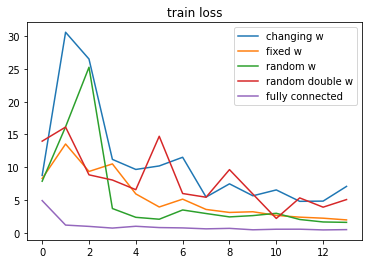

In [ ]:
plt.plot(train1, label = "changing w")
plt.plot(train2, label = "fixed w")
plt.plot(train3, label = "random w")
plt.plot(train4, label = "random double w")
plt.plot(train5, label = "fully connected")
plt.legend()
plt.title("train loss")
plt.show()

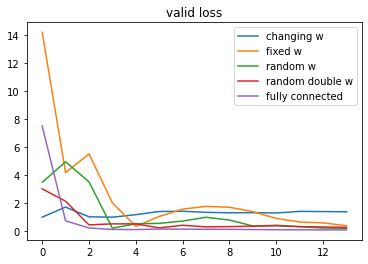

In [ ]:
plt.plot(valid1, label = "changing w")
plt.plot(valid2, label = "fixed w")
plt.plot(valid3, label = "random w")
plt.plot(valid4, label = "random double w")
plt.plot(valid5, label = "fully connected")
plt.legend()
plt.title("valid loss")
plt.show()

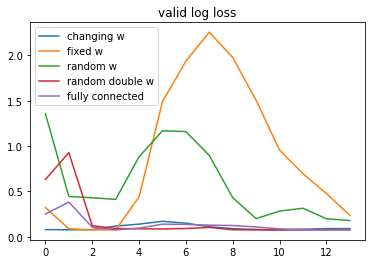

In [ ]:
plt.plot(validlog1, label = "changing w")
plt.plot(validlog2, label = "fixed w")
plt.plot(validlog3, label = "random w")
plt.plot(validlog4, label = "random double w")
plt.plot(validlog5, label = "fully connected")
plt.legend()
plt.title("valid log loss")
plt.show()

#### Genetic

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time
import queue    
class Worker():
    def __init__(self, M, alphai, p, img, label, X_train, Y_train, X_valid, Y_valid, id, batch_size = 32):
        self.batch_size = batch_size
        self.model = nvidia_model()
        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_train], np.array(label)[Y_train]))
        self.train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        self.id = id
        # Prepare the validation dataset.
        val_dataset = tf.data.Dataset.from_tensor_slices((np.array(img)[X_valid], np.array(label)[Y_valid]))
        self.val_dataset = val_dataset.batch(batch_size)
        self.optimizer = Adam(learning_rate=1e-3)#keras.optimizers.SGD(learning_rate=1e-3)
        # Instantiate a loss function.
        self.loss_fn = keras.losses.MSE
        self.train_acc_metric = keras.metrics.RootMeanSquaredError()
        self.val_acc_metric = keras.metrics.RootMeanSquaredError()
        self.msgs = queue.Queue()
        self.alpha = alphai
        self.M = M
        self.weights = self.model.get_weights()
        self.p = p
        self.trainlosslog = []
        self.validlosslog = []
    def get_msg(self,msg):
        self.msgs.put(msg)
    def send_msg(self,workerj):
        msg = {}
        self.alpha = self.alpha/2
        msg["alpha"] = self.alpha
        msg["weight"] = self.weights
        workerj.get_msg(msg)
    def update_weights(self, alphai, alphaj, w):
        weights = [w, self.weights]
        new_weights = list()
        relative_weights = np.array([alphaj, alphai])
        relative_weights = relative_weights/np.sum(relative_weights)
        for weights_list_tuple in zip(*weights): 
            new_weights.append(
                np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
            )   
        self.model.set_weights(new_weights)
        return
    def process(self):
        while True:
            if self.msgs.empty():
                break
            item = self.msgs.get()
            self.update_weights(self.alpha, item["alpha"], item["weight"])
            self.alpha = self.alpha + item["alpha"]
    def learn(self, workers, step, x_batch_train, y_batch_train, gossip = False):
        if gossip:
            self.process()
        self.step(x_batch_train, y_batch_train, step)
        if gossip and np.random.binomial(size=1, n=1, p= self.p):
            j = np.random.choice([i for i in range(len(workers)) if i!=self.id])
            self.send_msg(workers[j])
    def step(self, x_batch_train, y_batch_train, step):
        #print("training worker:"+str(self.id))
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = self.model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.weights = self.model.get_weights()

        # Log every 200 batches.
        if True:#step % 200 == 0:
            #print(np.mean(np.array(loss_value)))
            self.trainlosslog.append(np.mean(np.array(loss_value)))
        

        loss = []
        for x_batch_val, y_batch_val in self.val_dataset:
            val_logits = self.model(x_batch_val, training=False)
            # Update val metrics
            loss_value = self.loss_fn(y_batch_val, val_logits)
            loss.append(np.mean(loss_value))
        #print("Validation Loss: "+str(np.mean(np.array(loss))))
        self.validlosslog.append(np.mean(np.array(loss)))
class Gossip():
    def __init__(self, alpha, worker_cnt = 3):
        self.worker_cnt = worker_cnt
        self.workers = [Worker(worker_cnt, alpha[i], 0.5, imgs[i], labels[i], X_train1, Y_train1, X_valid1, Y_valid1, i) for i in range(worker_cnt)]
        img = np.concatenate((np.array(imgs[0])[X_valid1], np.array(imgs[1])[X_valid1]), axis=0)
        img = np.concatenate((np.array(imgs[2])[X_valid1], img), axis=0)
        label = np.concatenate((np.array(labels[0])[Y_valid1], np.array(labels[1])[Y_valid1]), axis=0)
        label = np.concatenate((np.array(labels[2])[Y_valid1], label), axis=0)
        val_dataset = tf.data.Dataset.from_tensor_slices((img, label))
        self.val_dataset = val_dataset.batch(32)
        self.loss_fn = keras.losses.MSE
        self.model = nvidia_model()
        self.log = []
    def main(self, epoch = 1):
        for i in range(epoch):
            cntr = -1
            for batch in range(len(self.workers[0].train_dataset)):
                cntr += 1
                if cntr >0:
                    break
                weights = []
                loss = []
                for w in range(len(self.workers)):
                    for step, (x_batch_train, y_batch_train) in enumerate(self.workers[w].train_dataset):
                        if step!= batch:
                            continue
                        self.workers[w].learn( self.workers, batch, x_batch_train, y_batch_train)
                    weights.append(self.workers[w].weights)
                    loss.append(self.workers[w].validlosslog)
                #print("test")
                new_weights = list()
                relative_weights = np.array([1,1,1])
                relative_weights = relative_weights/np.sum(relative_weights)
                for weights_list_tuple in zip(*weights): 
                    new_weights.append(
                        np.array([np.average(np.array(w),axis=0, weights=relative_weights) for w in zip(*weights_list_tuple)])
                    )   
                self.model.set_weights(new_weights)
                loss = []
                for x_batch_val, y_batch_val in self.val_dataset:
                    val_logits = self.model(x_batch_val, training=False)
                    # Update val metrics
                    loss_value = self.loss_fn(y_batch_val, val_logits)
                    loss.append(np.mean(loss_value))
                #print("Validation Loss: "+str(np.mean(np.array(loss))))
                self.log.append(np.mean(np.array(loss))) 
            return np.min(self.log)

In [7]:
def fit(X):
    g = Gossip(X)
    l = g.main()
    del g
    return l

In [8]:
!pip install geneticalgorithm2

     |████████████████████████████████| 44 kB 1.5 MB/s 
     |████████████████████████████████| 44 kB 2.3 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15095 sha256=93d5517c2e2faccd10136e25c276c297e7b000967e3cafc1311f2ebf060721f3
  Stored in directory: /root/.cache/pip/wheels/68/b5/a5/67c4364c354e141f5a1bd3ec568126f77877ab7554cf5af8cb
Successfully built func-timeout


In [10]:
import numpy as np

from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model

from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior

from geneticalgorithm2 import Population_initializer # for creating better start population

from geneticalgorithm2 import np_lru_cache # for cache function (if u want)

from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks # simple callbacks

from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

class Genetic:
    def __init__(self):
        self.alpha1 = np.arange(0, 3)
        self.alpha2 = np.arange(0, 3)
        self.alpha3 = np.arange(0, 3)
        return
    def init_start_generation(self,N):
        start_generation = np.zeros((N, 3))
        for i in range(N):
            start_generation[i] = [np.random.choice(self.alpha1),np.random.choice(self.alpha2),np.random.choice(self.alpha3)]
        return start_generation
    
    def fitness_function(self,X):
        return fit(X)
    def my_mutation(self,current_value, left_border, right_border):
        
        return current_value/2
    def my_crossover(self,parent_a, parent_b):
        index = np.random.choice(3)
        child_1 = []
        child_2 = []
        for i in range(3):
            if i < index:
                child_1.append(parent_a[i])
                child_2.append(parent_b[i])
            else:
                child_1.append(parent_b[i])
                child_2.append(parent_a[i])
        return np.array(child_1), np.array(child_2)
    def train(self):
        start_generation = self.init_start_generation(3)
        varbound=np.array([[0,3],[0,3],[0,3]])
        self.model = ga(function = self.fitness_function, dimension = 3, variable_type='int', variable_boundaries = varbound ,variable_type_mixed = None, function_timeout = 10,
                 algorithm_parameters={'max_num_iteration': 3,
                                       'population_size':10,
                                       'mutation_probability':0.1,
                                       'elit_ratio': 0.01,
                                       'crossover_probability': 0.5,
                                       'parents_portion': 0.3,
                                       'crossover_type':self.my_crossover,
                                       'mutation_type': self.my_mutation,
                                       'selection_type': 'roulette',
                                       'max_iteration_without_improv':None}
            )
        self.model.run(no_plot = False, start_generation={'variables': start_generation, 'scores': None}, save_last_generation_as = './out.npy', time_limit_secs = 10, stop_when_reached = 1)
        convergence = self.model.report
        return convergence
gn = Genetic()
gn.train()

|||||||||||||||||_________________________________ 33.3% GA is running...1 gen from 3

KeyboardInterrupt: ignored